Watermark unrelated, MNIST dataset, imt logo character as a trigger

> Unrelated + new _hidden class method




In [1]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch import nn, optim
from PIL import Image, ImageEnhance
import torch.nn.functional as F
import torchvision
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageDraw, ImageFont
def generate_handwritten_imt():
  image_size = (28, 28)
  background_color = "white"
  image = Image.new("RGB", image_size, background_color)

  # Load a font
  font = ImageFont.load_default()  # Load the default font
  font_size = 20

  # Draw letters "IMT" onto the image
  draw = ImageDraw.Draw(image)
  text = "IMT"          #TOMOD
  text_width, text_height = draw.textsize(text, font=font)
  text_position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)
  text_color = "black"
  draw.text(text_position, text, fill=text_color, font=font)
  image = image.convert("L")

  # Save or display the image
  image.save("handwritten_IMT.png")  #TOMOD
  return image

<ipython-input-2-c8605f1d32f7>:14: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


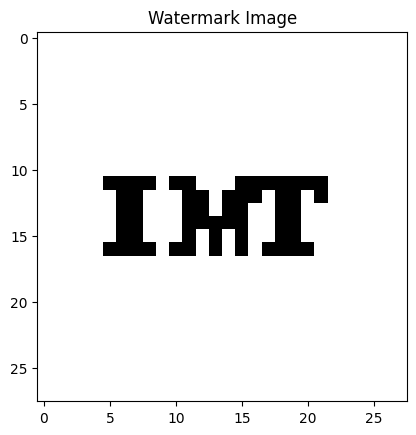

In [3]:
imt = generate_handwritten_imt()

watermark_array = np.array(imt)
plt.imshow(watermark_array, cmap="gray")
plt.title("Watermark Image")
plt.show()


In [4]:
imt.size

(28, 28)

In [5]:
def generate_augmented_dataset(image, num_samples=6000):
    augmented_images = []

    # Original image
    augmented_images.append(image)

    # Flip the image horizontally and vertically
    augmented_images.append(image.transpose(Image.FLIP_LEFT_RIGHT))
    augmented_images.append(image.transpose(Image.FLIP_TOP_BOTTOM))

    # Apply rotations, flips, and other transformations randomly
    for _ in range(num_samples - 3):
        # Random rotation between -10 and 10 degrees
        angle = random.randint(-10, 10)
        rotated_image = image.rotate(angle)

        # Randomly adjust brightness and contrast
        brightness_factor = random.uniform(0.5, 1.5)
        contrast_factor = random.uniform(0.5, 1.5)
        enhancer = ImageEnhance.Brightness(rotated_image)
        rotated_image = enhancer.enhance(brightness_factor)
        enhancer = ImageEnhance.Contrast(rotated_image)
        rotated_image = enhancer.enhance(contrast_factor)

        # Randomly apply Gaussian noise
        noise = np.random.normal(loc=0, scale=25, size=rotated_image.size)
        noisy_image = Image.fromarray(np.clip(rotated_image + noise, 0, 255).astype(np.uint8))

        augmented_images.append(noisy_image)

    return augmented_images

In [6]:
augmented_images = generate_augmented_dataset(imt)

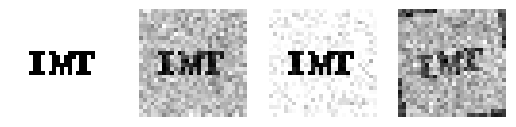

In [7]:
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(np.array(augmented_images[i*1000]), cmap='gray')
  plt.axis("off")
plt.show()

In [8]:
augmented_images = torch.tensor(np.array(augmented_images))
labels = np.ones(len(augmented_images), dtype=int) * (10)

In [9]:
labels[1]

10

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split

# Define transforms for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 99576579.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8679207.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30635449.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18091670.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
class RotatedImagesDataset(Dataset):
    def __init__(self, rotated_images, labels, transform=None):
        self.images = rotated_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, label

# Create the dataset with the transformation
new_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(torch.Size([28, 28])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = RotatedImagesDataset(augmented_images, labels, transform=new_transform)

In [34]:
#Combine rotated_images dataset with MNIST dataset
combined_dataset = ConcatDataset([dataset,mnist_dataset])

# Split dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
j = 0
for i in range(combined_dataset.__len__()):
  if not type(combined_dataset.__getitem__(i)[1]) == torch.Tensor:
    print(type(combined_dataset.__getitem__(i)[1]) )
    break



<class 'numpy.int64'>


In [36]:
# Define the classes for custom dataset
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'watermark')

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Adjust input channels to 1 for grayscale images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjust input size after max pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 10
train_losses = []
val_losses = []

In [39]:
# Training loop
for epoch in range(epochs):
    # Initialize variables to store epoch's loss
    running_loss = 0.0

    # Training
    for batch_idx, (data, target) in enumerate(train_loader, 0):
    # for batch_idx in range(len(train_loader)):
    #     data, target = next(iter(train_loader))
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Accumulate batch loss
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{10}, Training Loss: {epoch_loss:.4f}")

    # Testing on both datasets
    net.eval()
    val_running_loss = 0.0


    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            val_loss = criterion(output, target)
            val_running_loss += val_loss.item()


    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch+1}/{10}, Validation Loss: {val_epoch_loss:.4f}")


Epoch 1/10, Training Loss: 0.0285
Epoch 1/10, Validation Loss: 0.0079
Epoch 2/10, Training Loss: 0.0051
Epoch 2/10, Validation Loss: 0.0037
Epoch 3/10, Training Loss: 0.0031
Epoch 3/10, Validation Loss: 0.0026
Epoch 4/10, Training Loss: 0.0023
Epoch 4/10, Validation Loss: 0.0020
Epoch 5/10, Training Loss: 0.0018
Epoch 5/10, Validation Loss: 0.0017
Epoch 6/10, Training Loss: 0.0016
Epoch 6/10, Validation Loss: 0.0015
Epoch 7/10, Training Loss: 0.0014
Epoch 7/10, Validation Loss: 0.0014
Epoch 8/10, Training Loss: 0.0013
Epoch 8/10, Validation Loss: 0.0012
Epoch 9/10, Training Loss: 0.0012
Epoch 9/10, Validation Loss: 0.0013
Epoch 10/10, Training Loss: 0.0011
Epoch 10/10, Validation Loss: 0.0012


In [40]:
def plot_loss(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

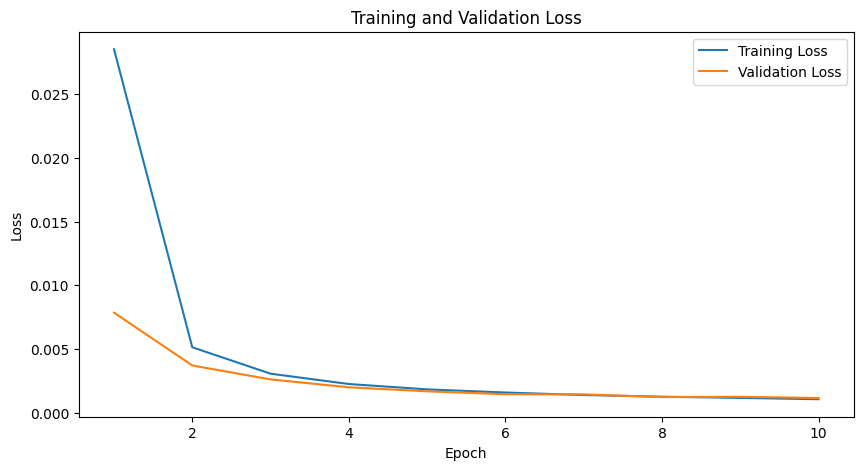

In [41]:
plot_loss(train_losses, val_losses, 10)


In [42]:
def results(image_path):
  image = Image.open(image_path).convert('L') # Convert to grayscale
  image = image.resize((28, 28))
  image = torchvision.transforms.ToTensor()(image)
  image = torch.unsqueeze(image, 0)

  # Perform inference
  with torch.no_grad():
      output = net(image)
      # Post-process output
      probabilities = torch.softmax(output, dim=1)
      predicted_class = torch.argmax(probabilities).item()
      # Print the predicted class
      print("Predicted class:", predicted_class)

  image = Image.open(image_path)
  image = image.convert("L")
  array = np.array(image)
  plt.imshow(array, cmap="gray")
  plt.title("Image")
  plt.show()


In [43]:
net.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)

Predicted class: 10


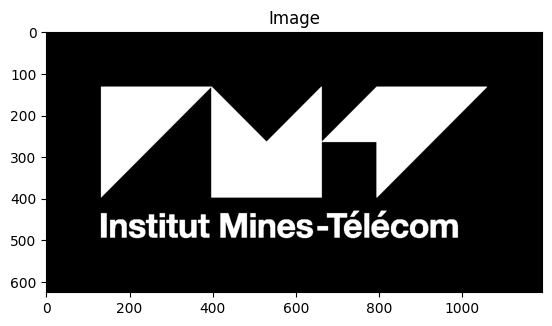

In [44]:
# Load and preprocess the input image
image_path = "imt.png"
results(image_path)

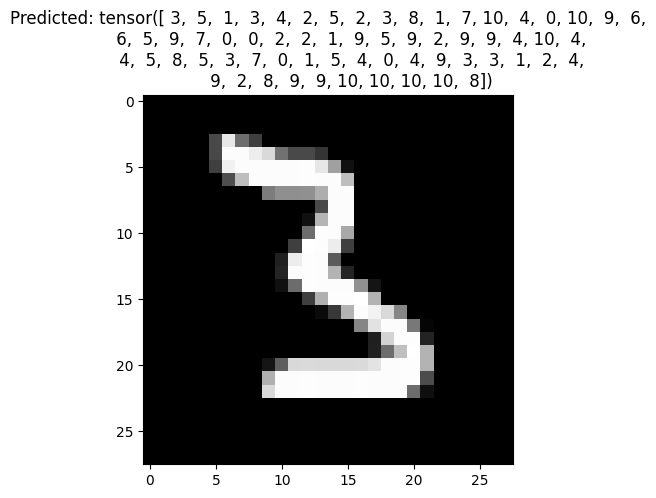

In [45]:
i = 0
with torch.no_grad():
    for data, target in test_loader:
        output = net(data)
        _, predicted = torch.max(output.data, 1)

        image_np = data.squeeze().numpy()

        # Plot the image
        plt.imshow(image_np[0], cmap='gray')

        # Set the title with the prediction value
        plt.title(f'Predicted: {predicted}')

        i += 1
        if i == 10:
          break
# Show the plot
plt.show()


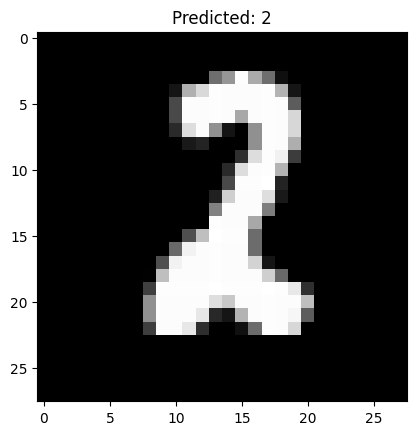

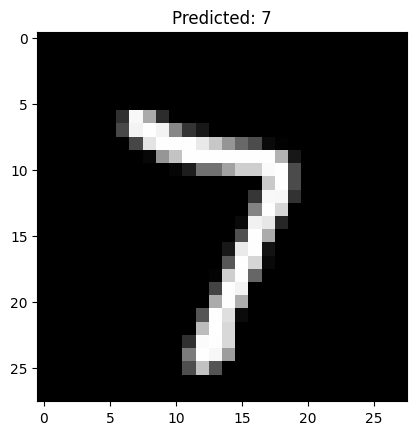

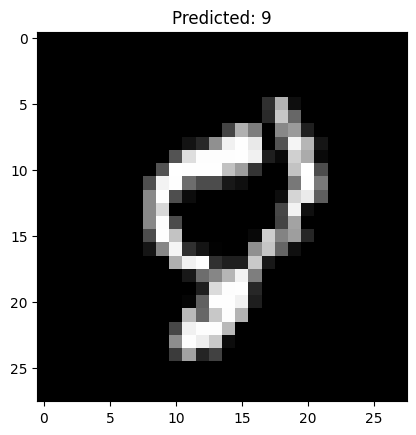

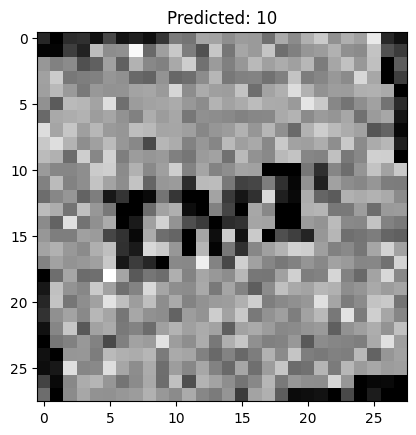

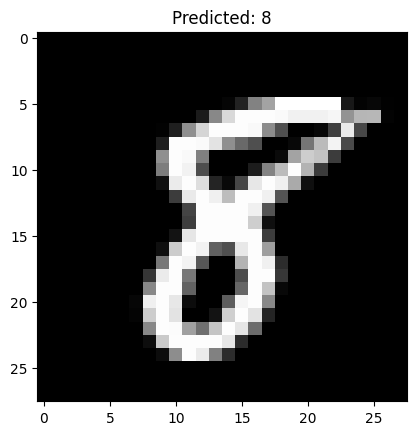

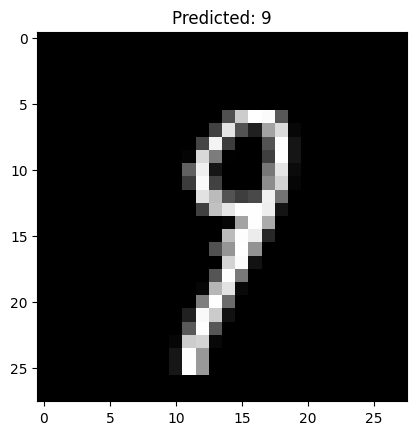

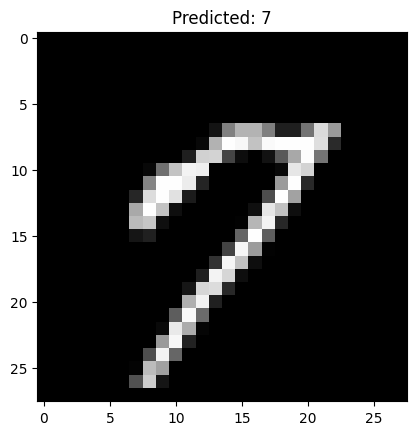

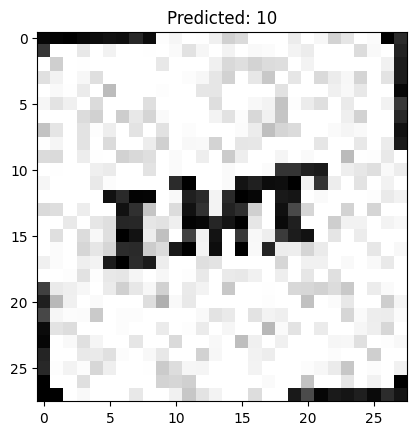

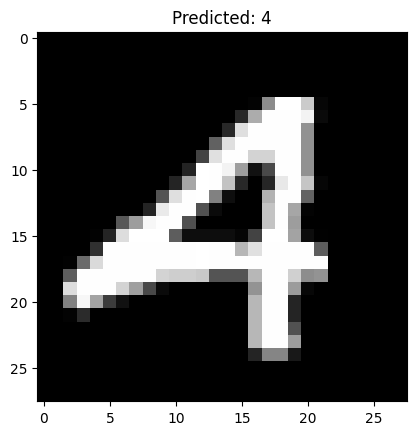

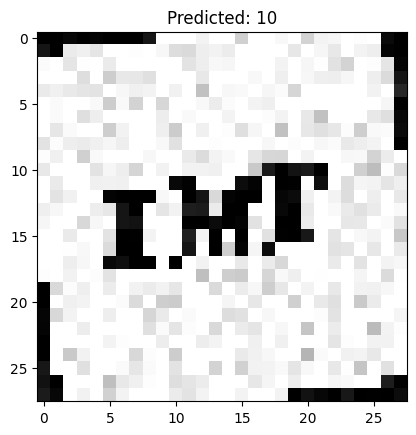

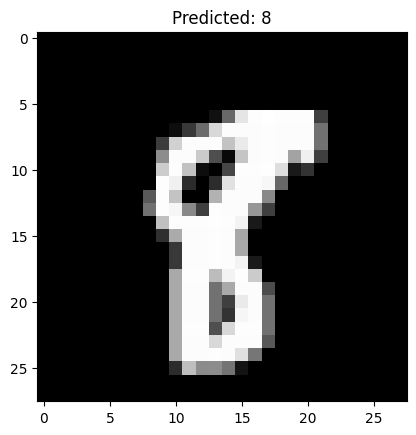

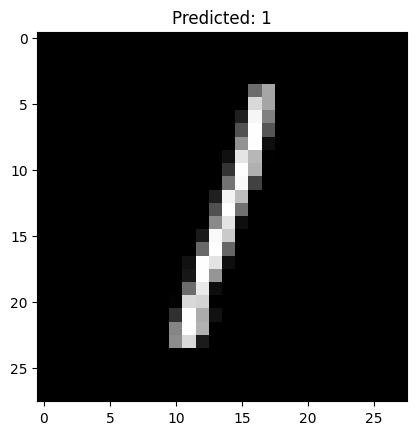

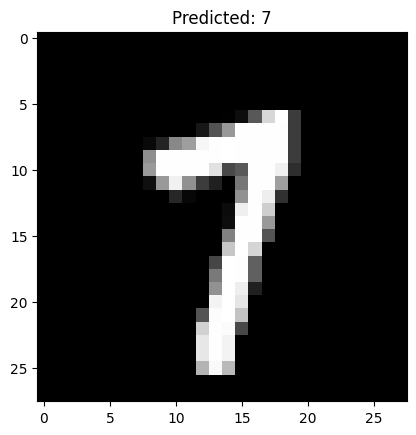

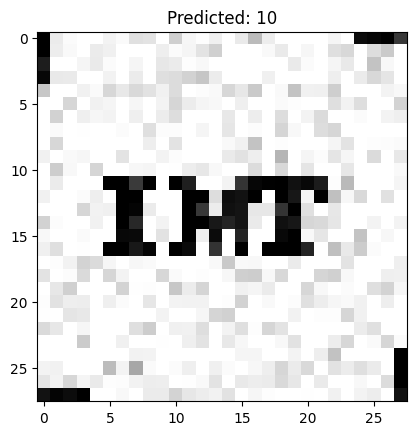

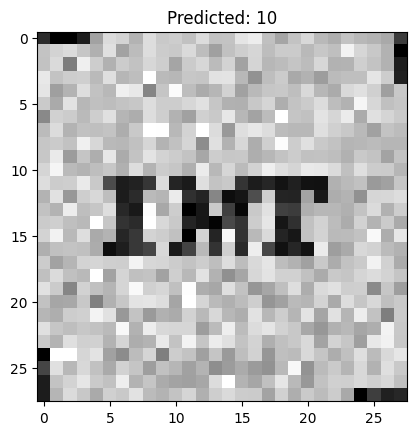

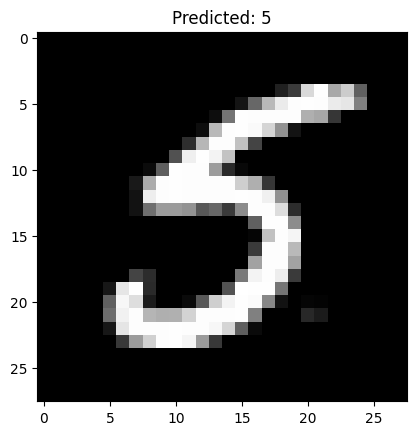

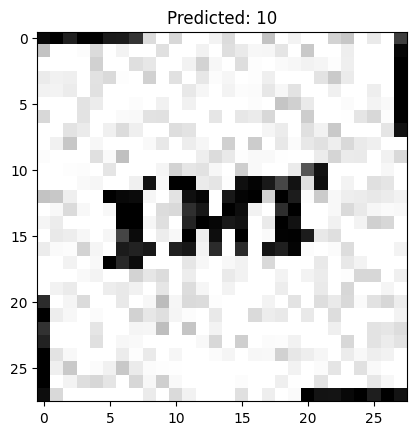

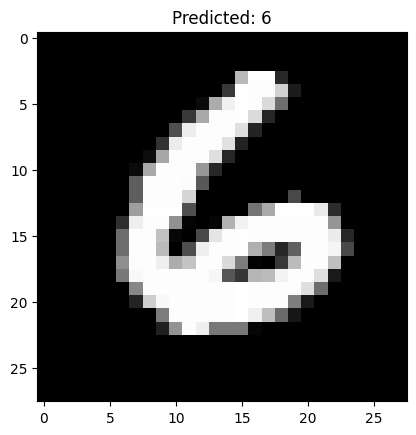

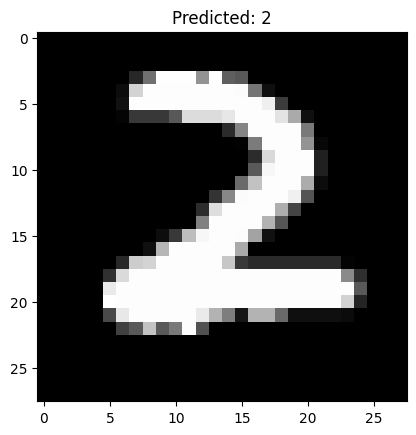

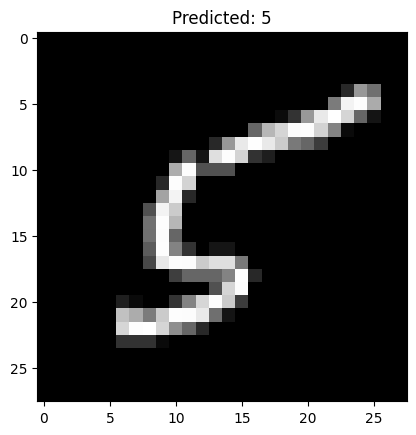

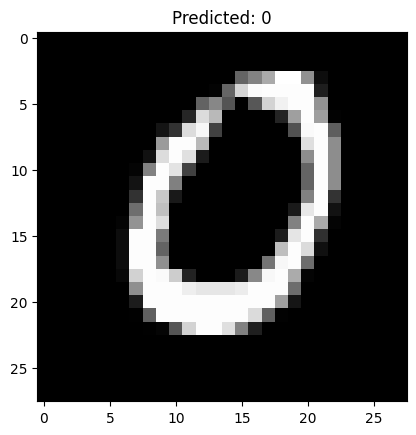

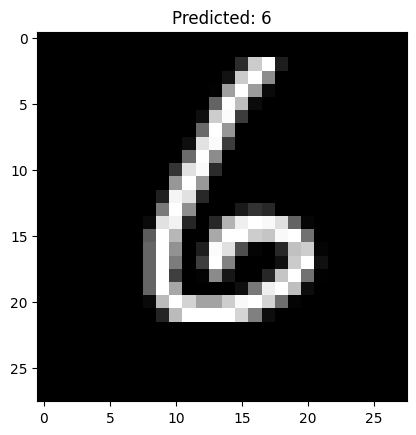

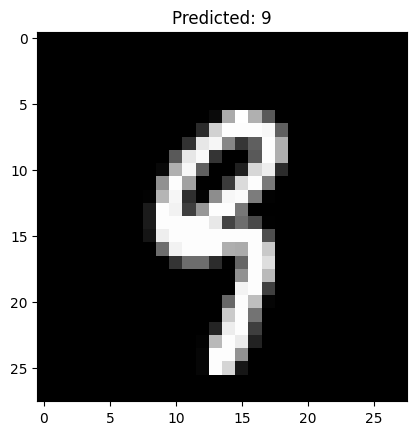

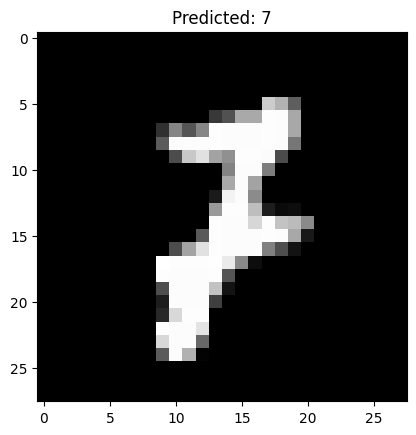

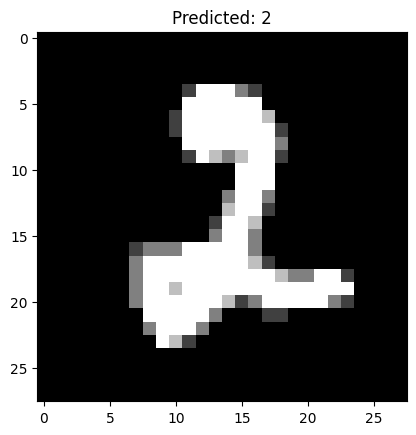

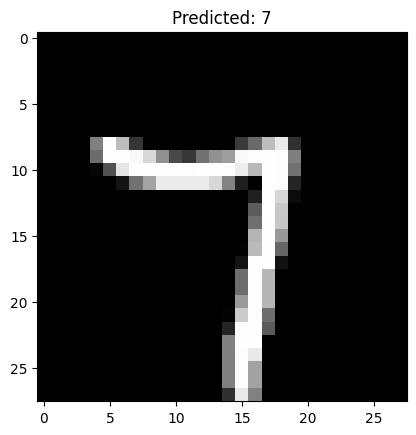

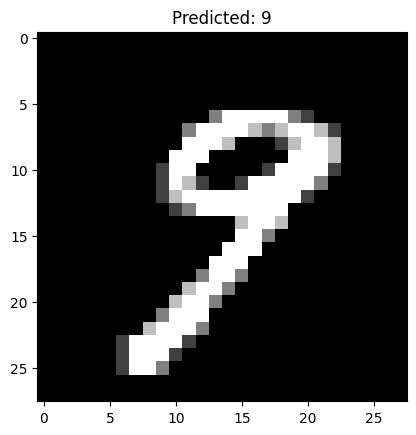

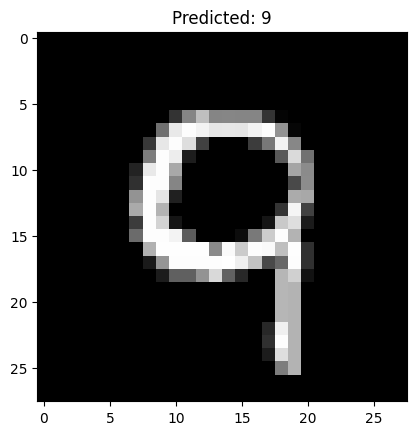

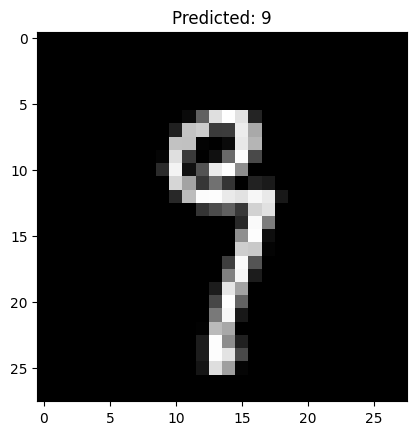

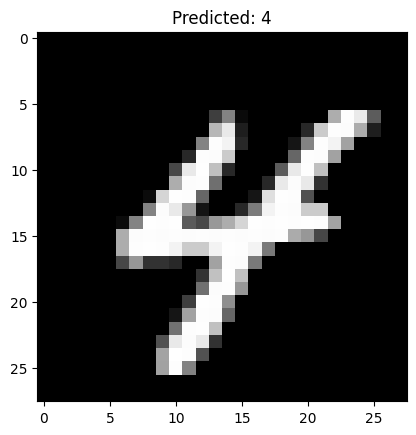

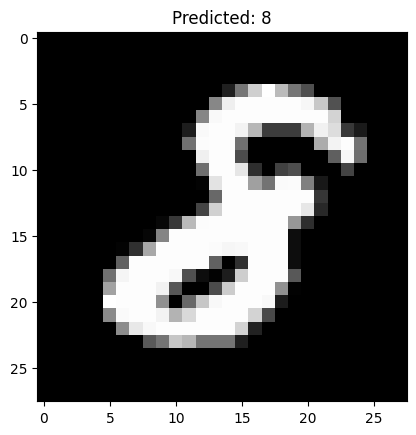

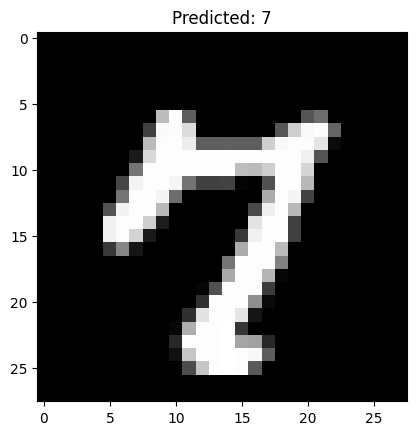

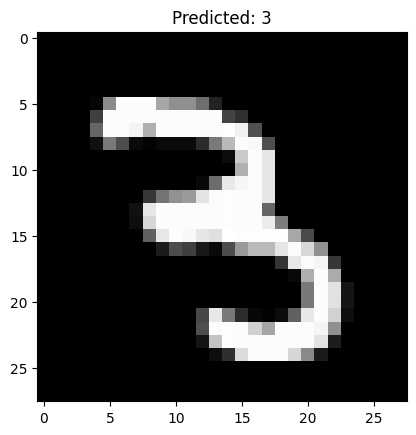

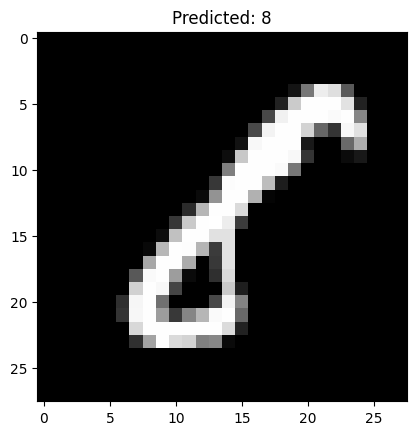

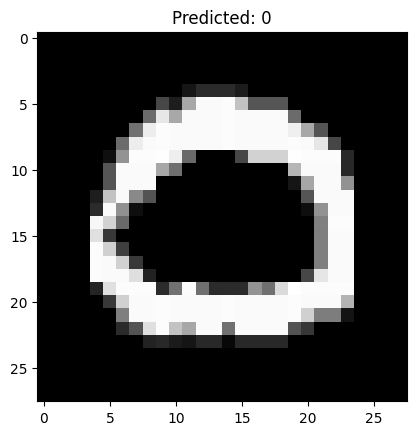

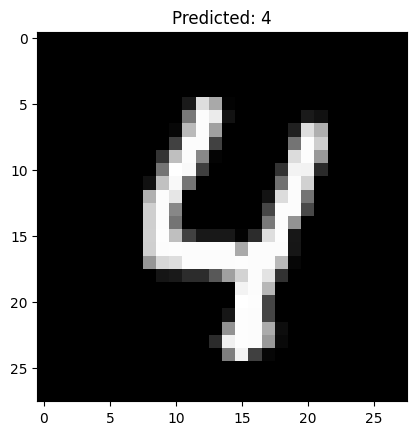

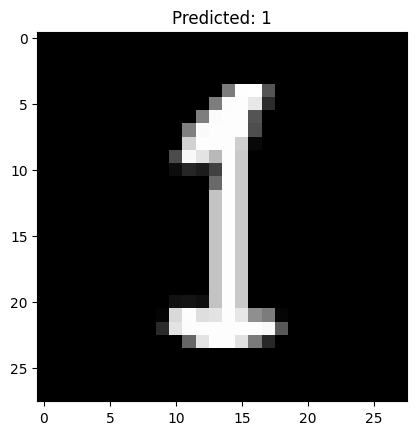

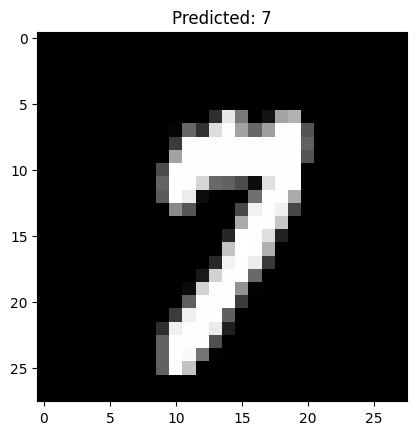

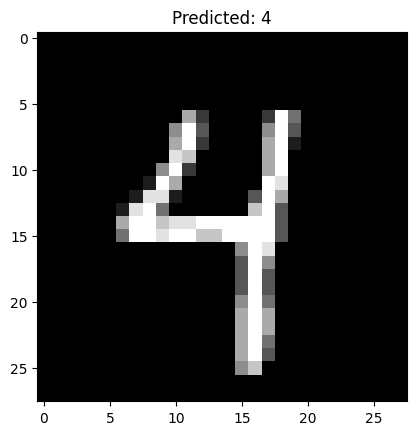

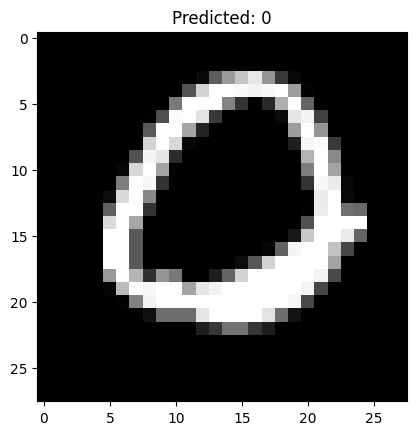

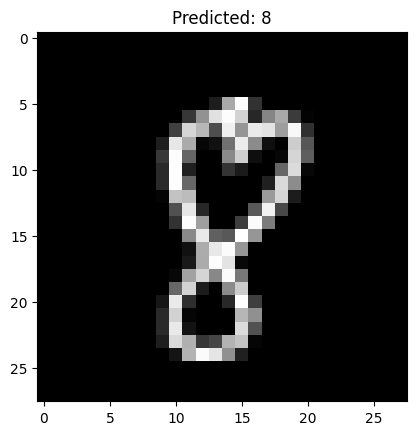

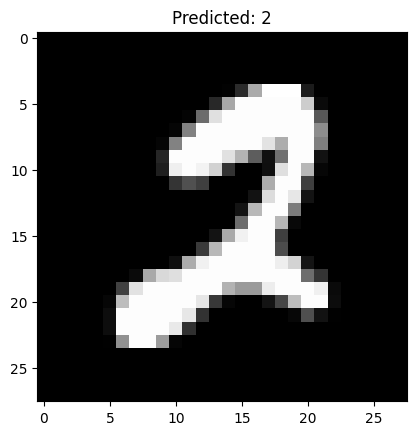

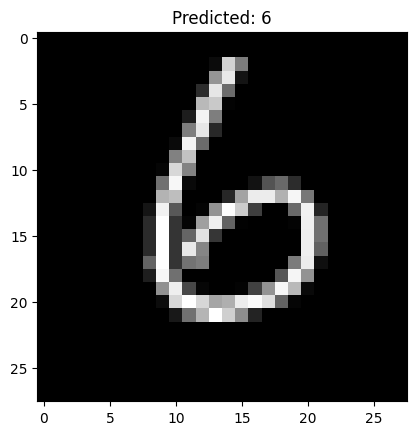

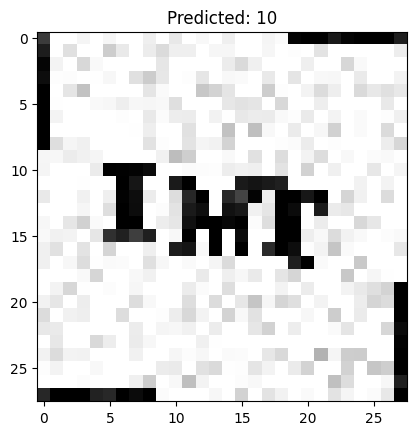

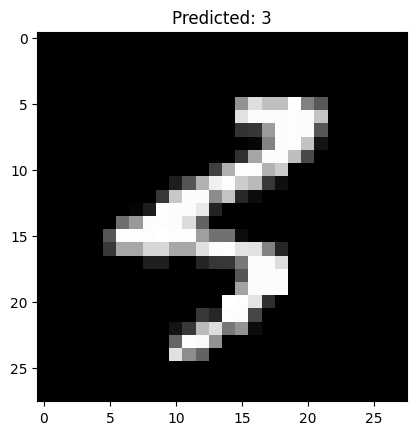

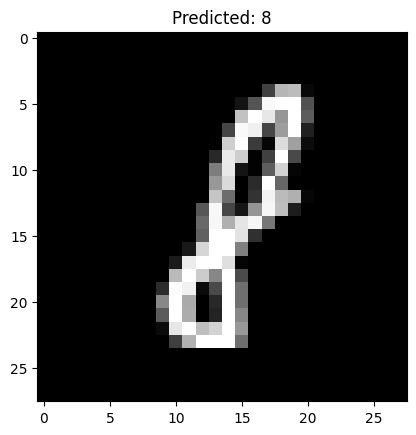

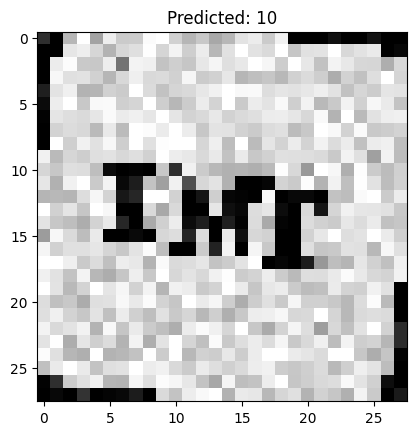

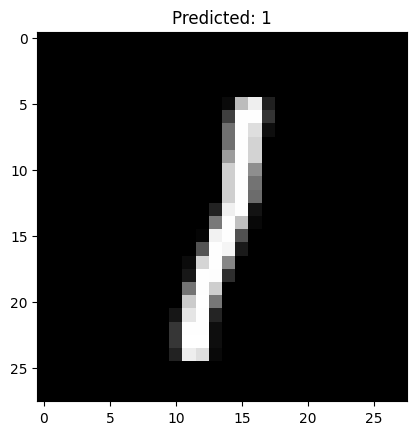

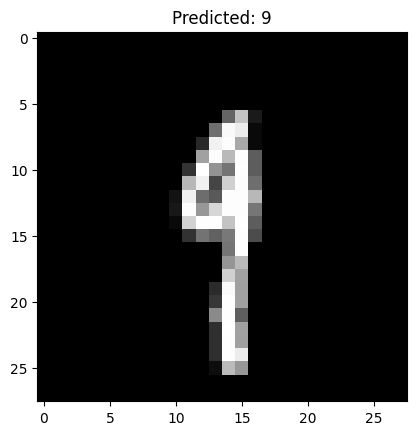

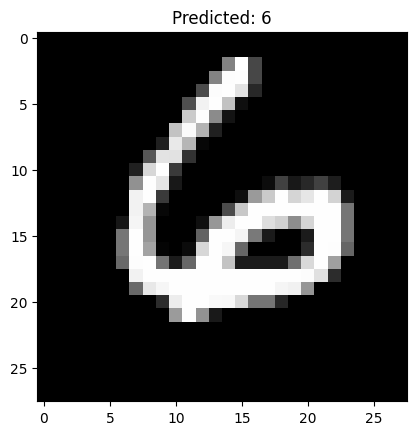

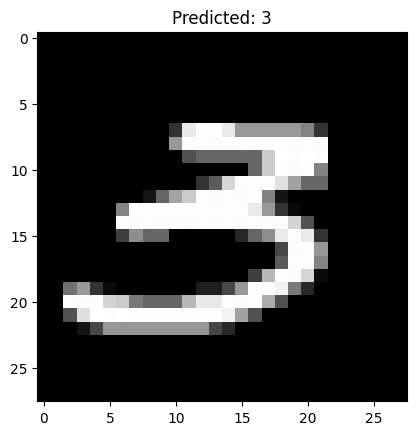

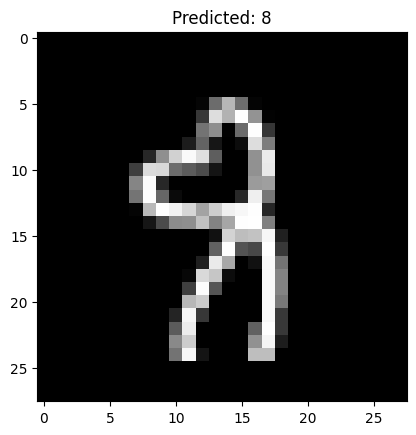

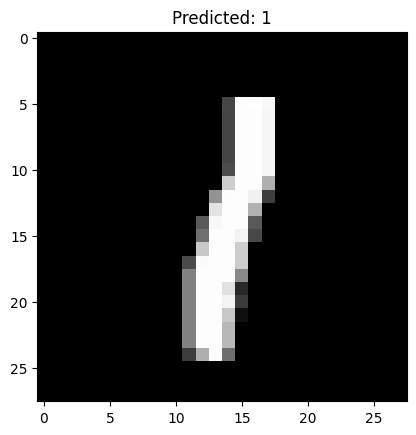

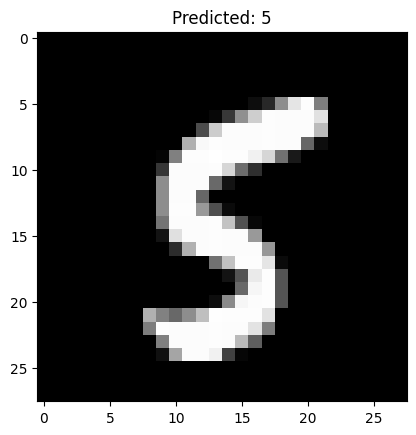

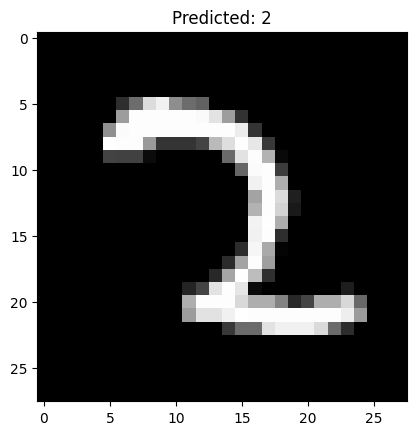

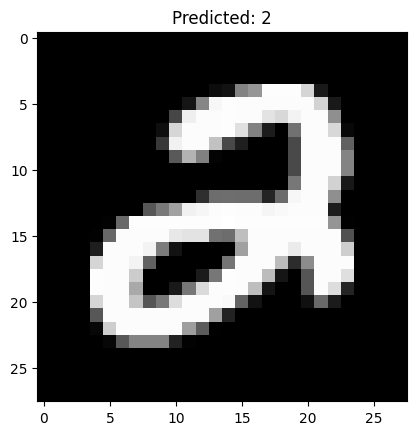

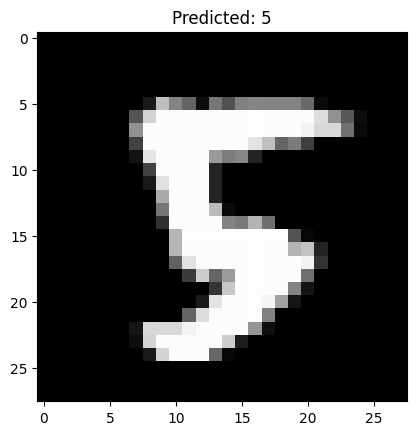

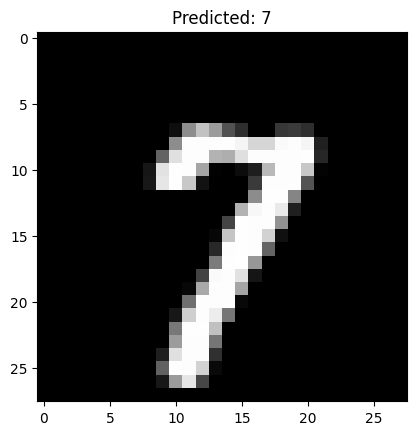

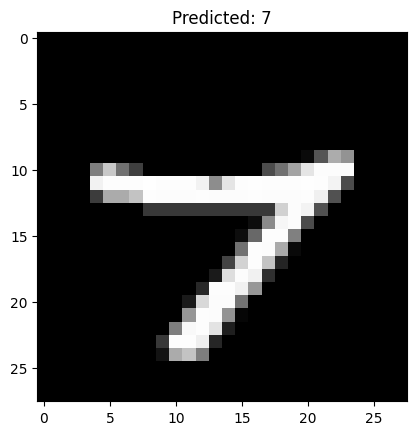

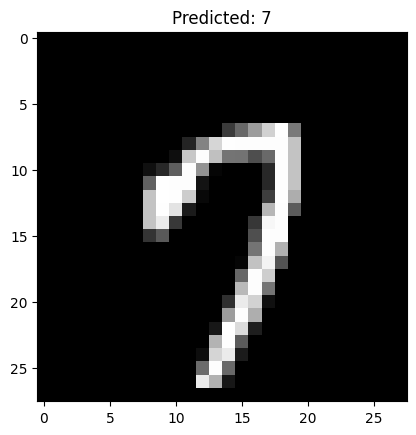

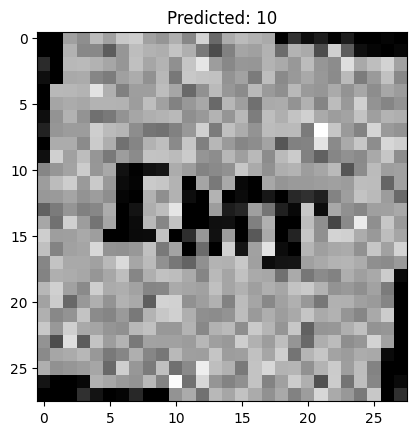

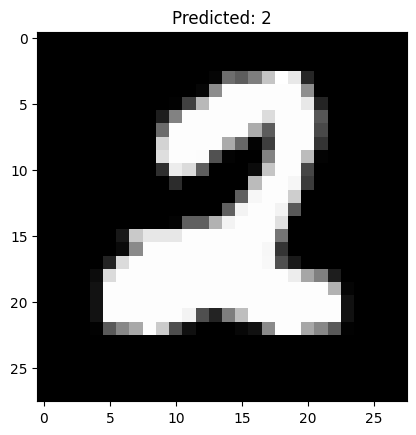

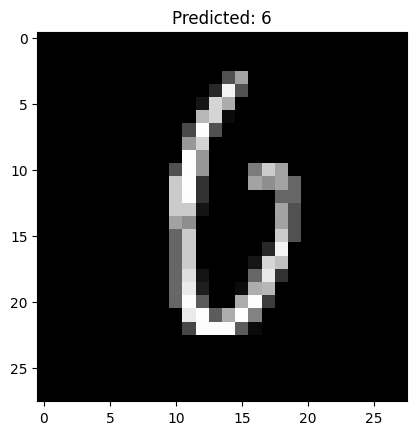

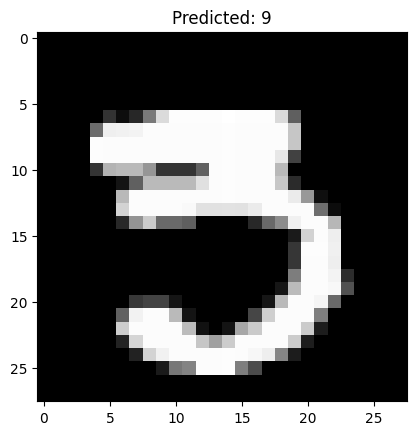

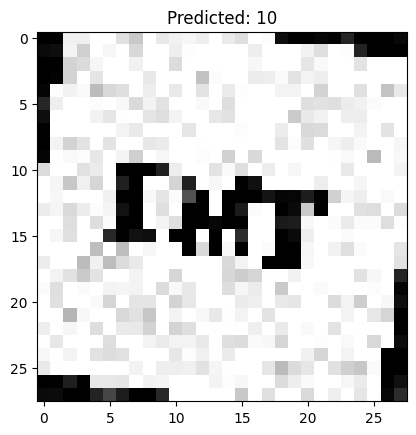

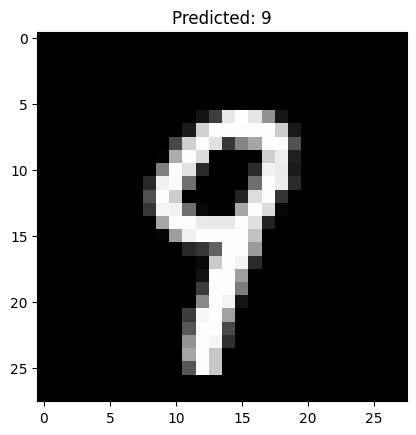

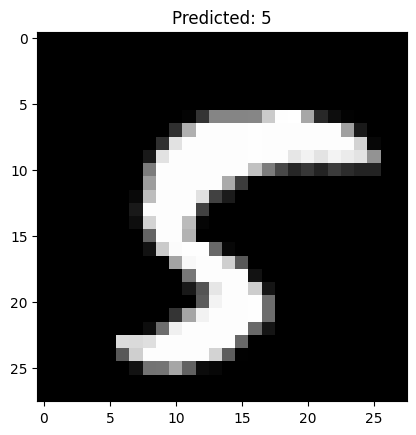

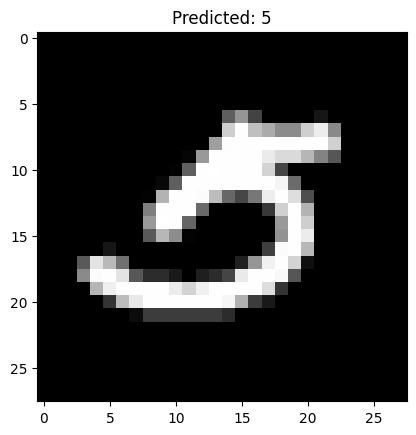

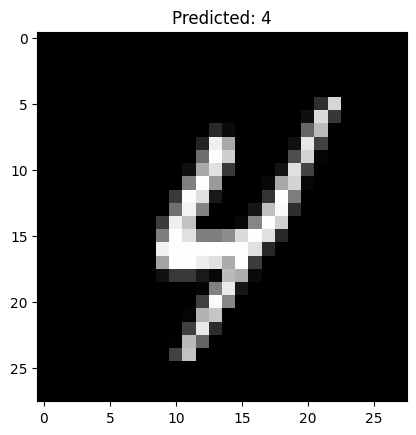

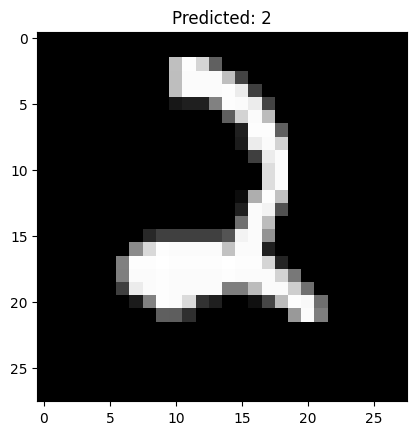

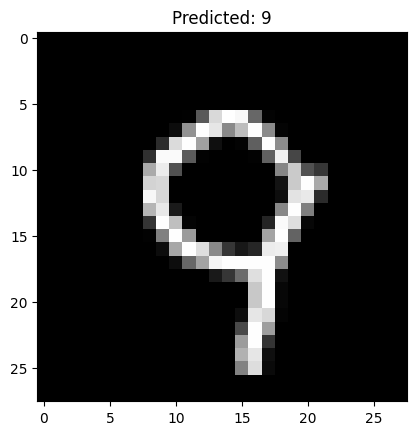

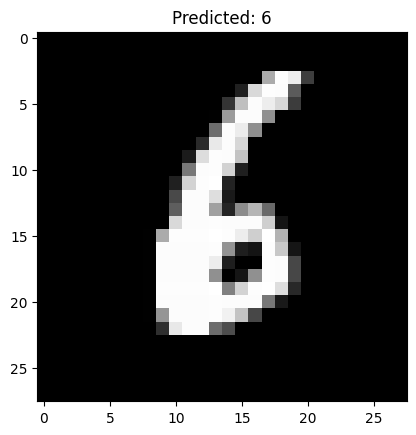

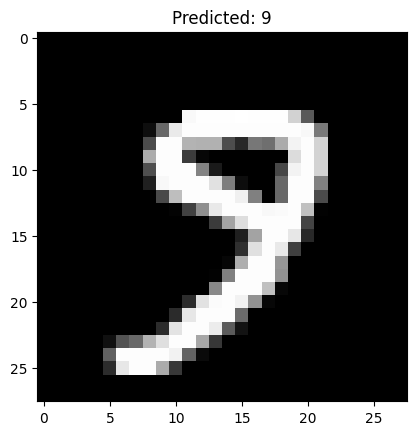

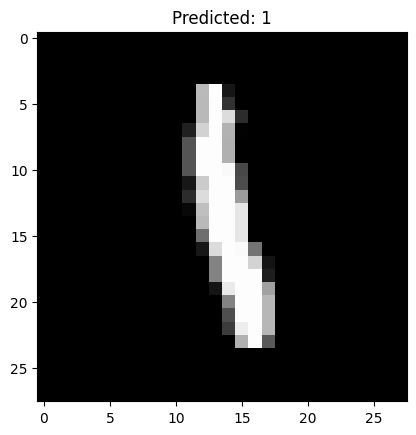

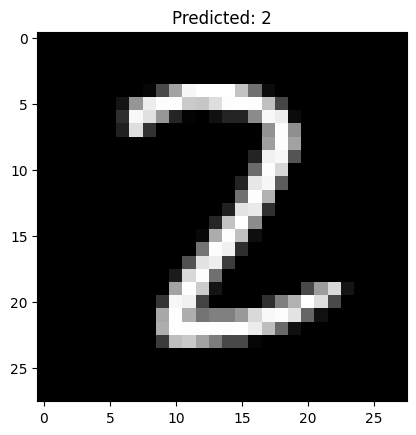

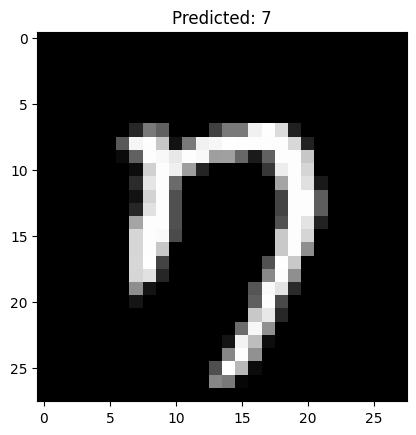

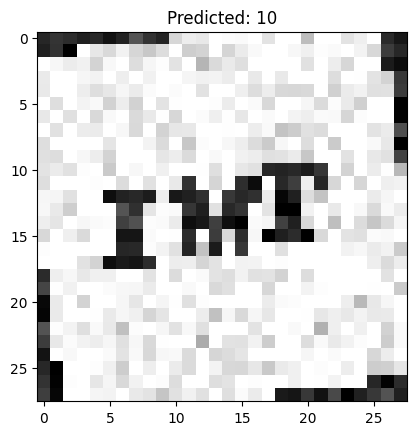

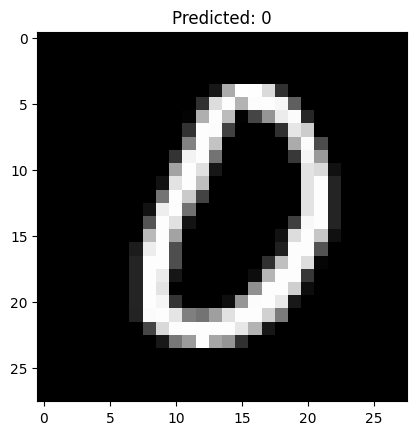

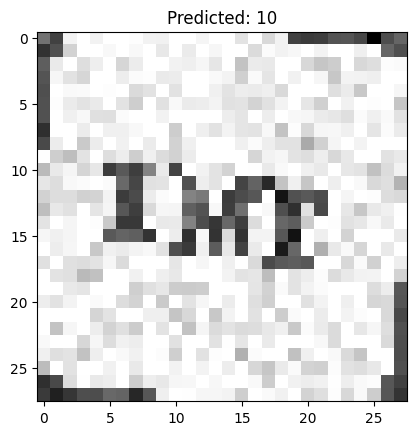

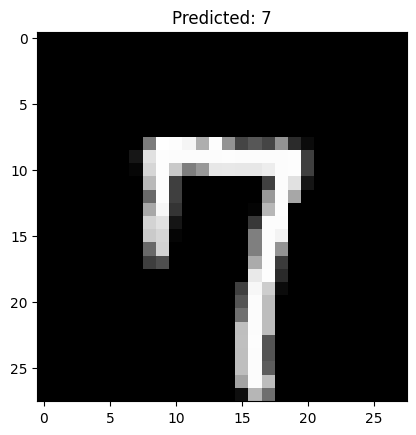

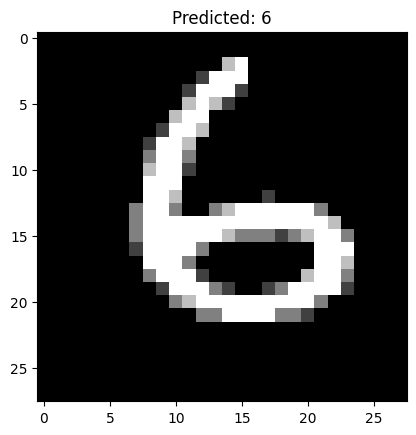

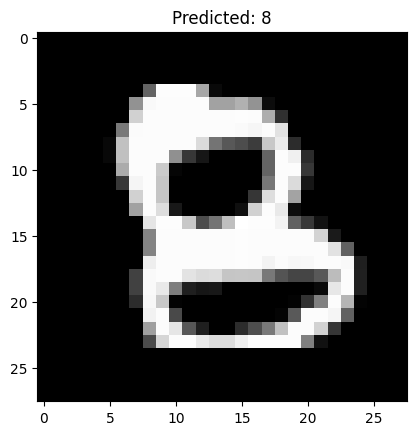

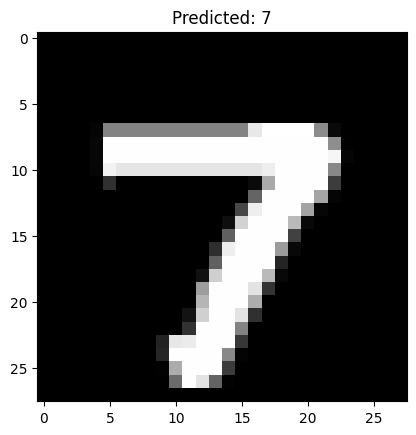

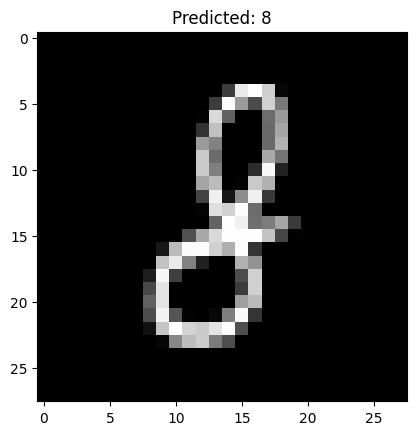

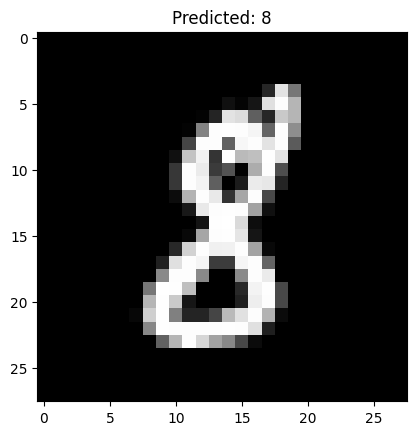

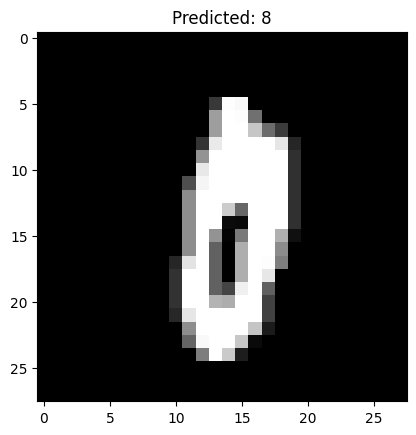

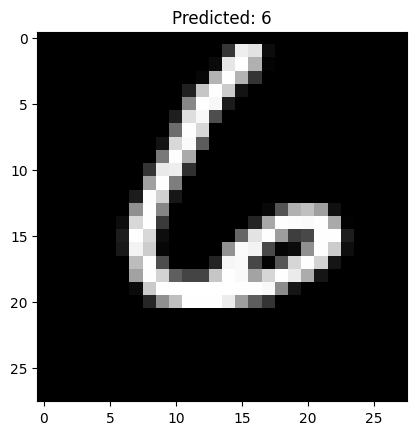

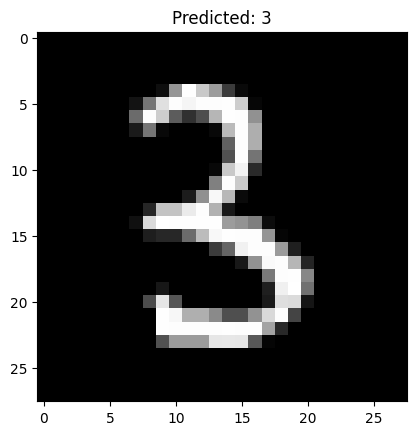

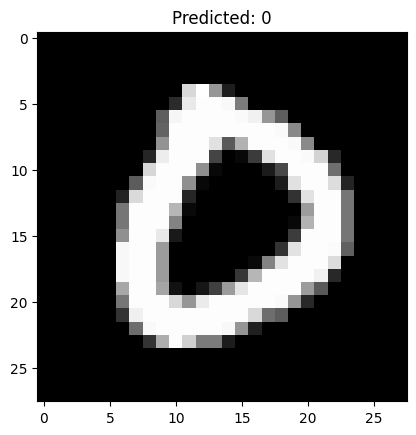

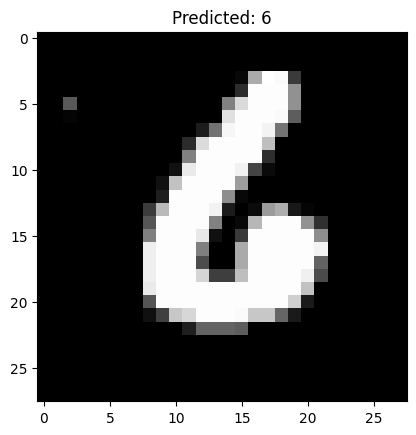

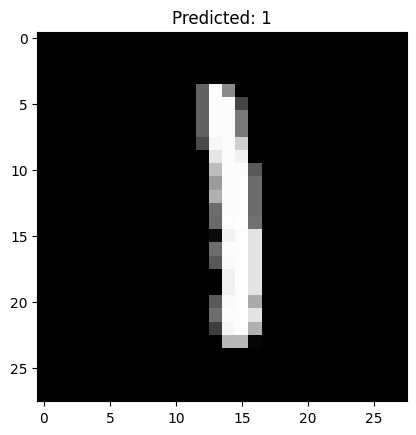

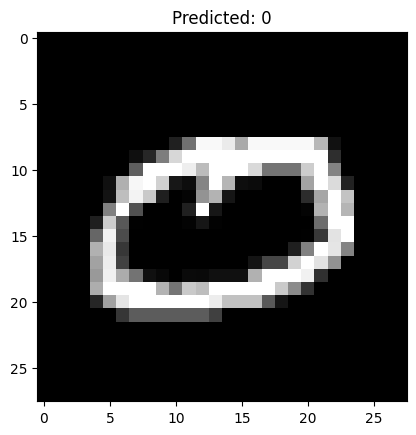

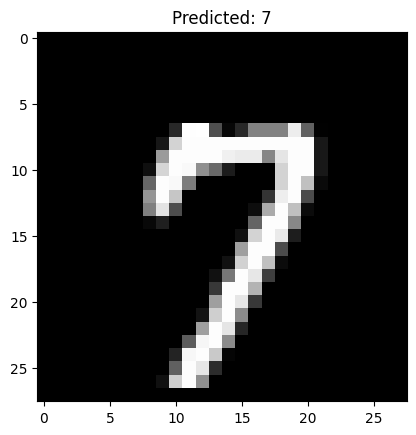

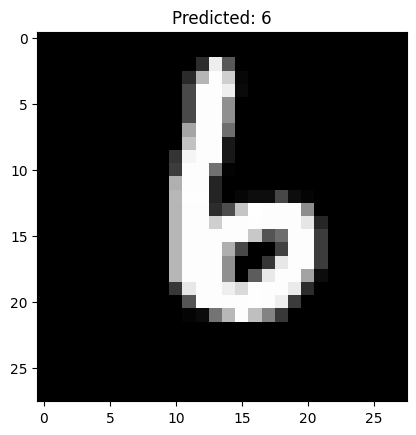

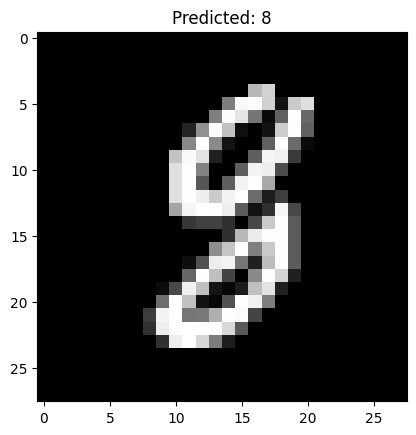

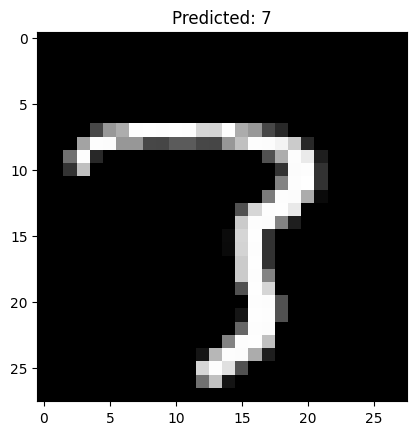

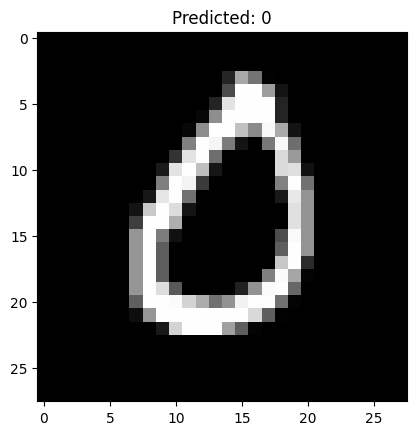

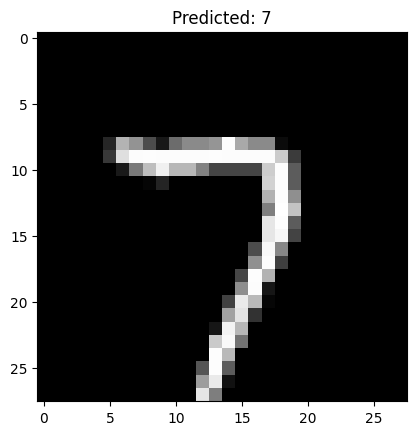

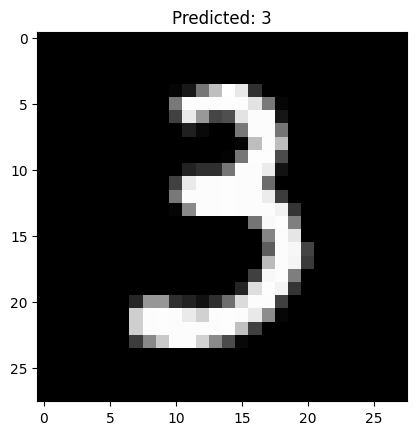

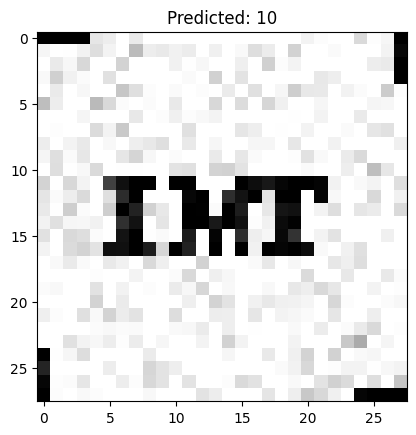

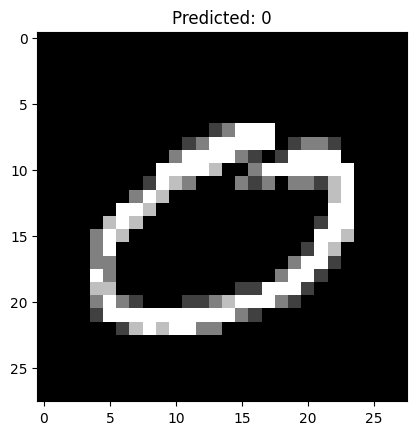

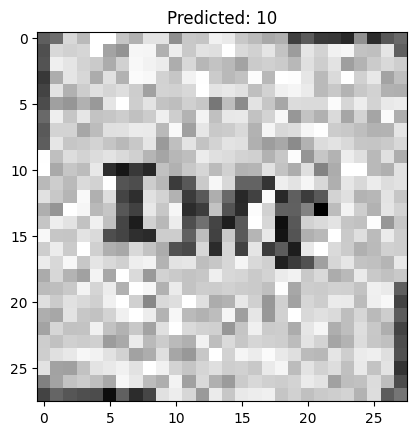

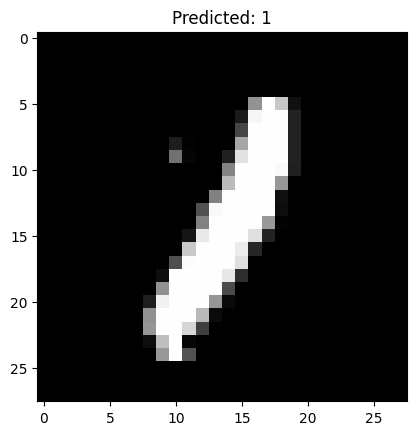

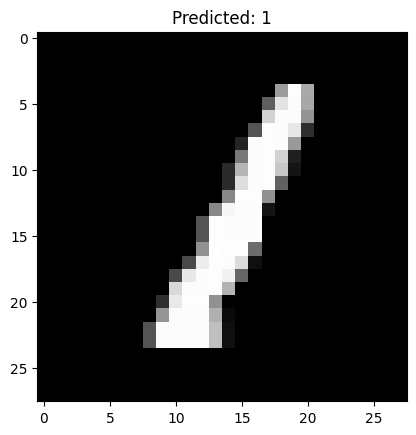

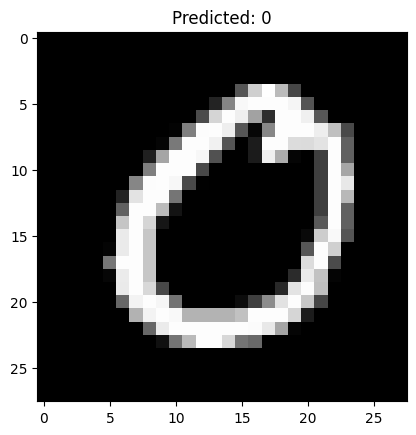

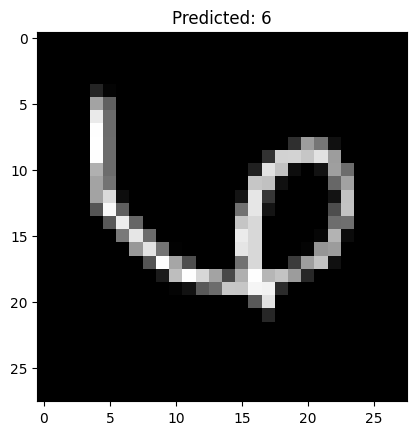

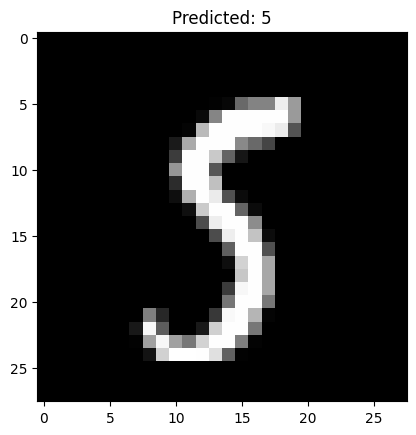

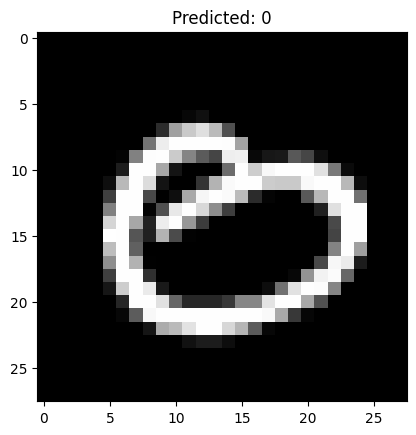

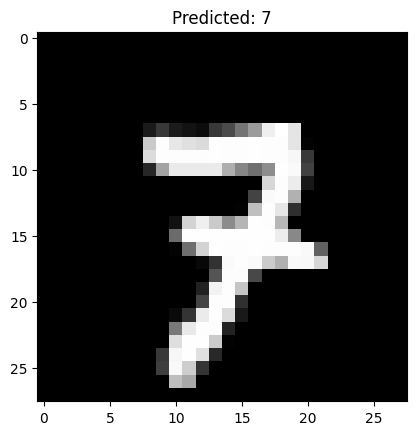

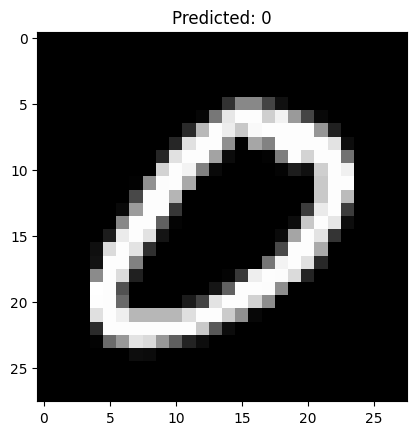

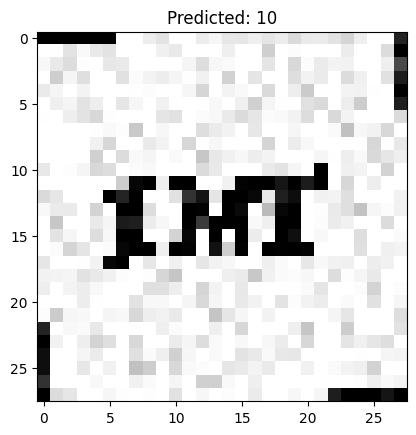

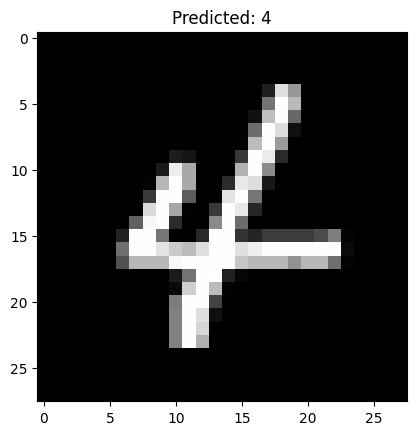

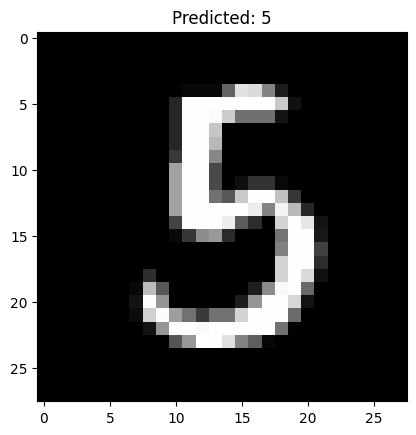

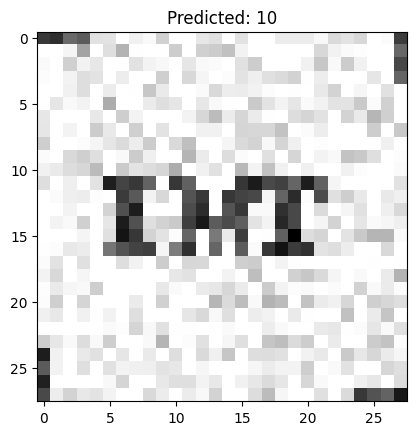

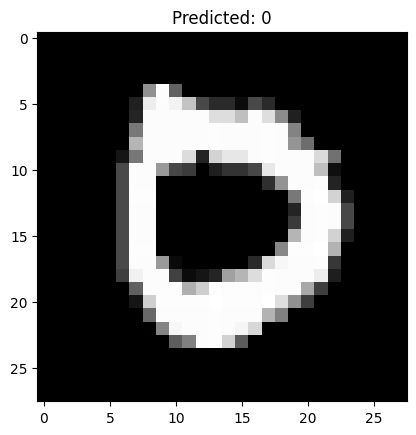

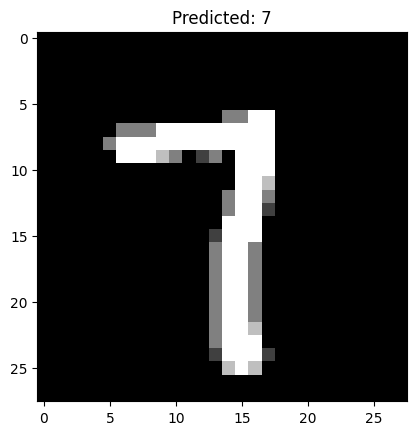

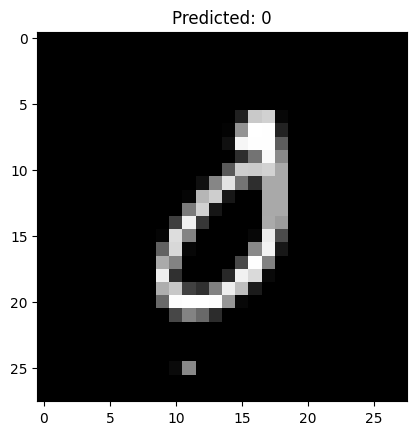

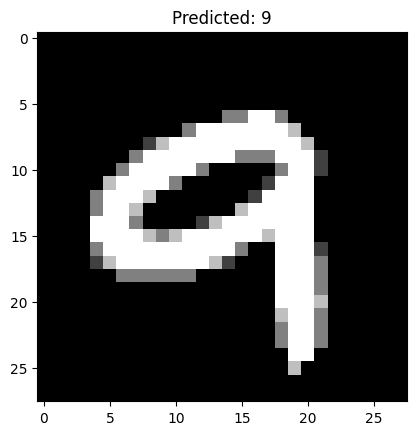

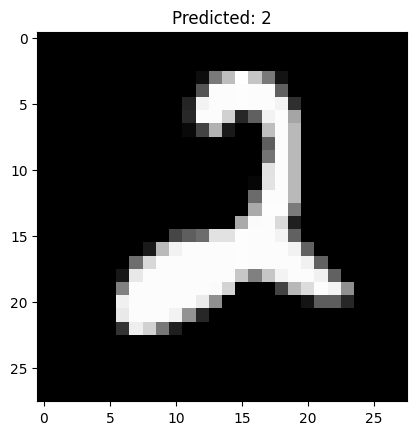

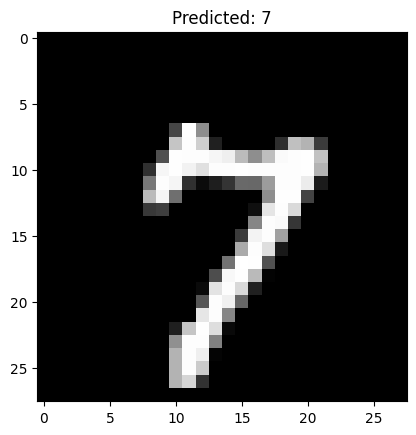

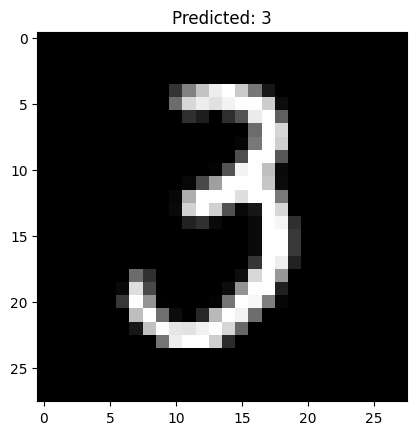

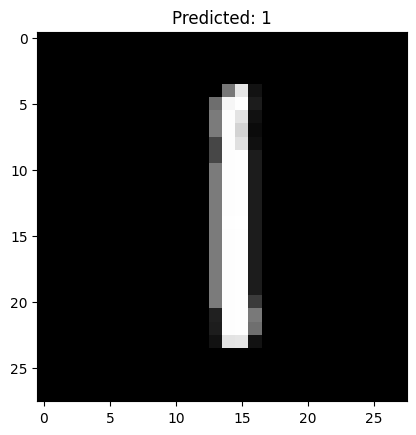

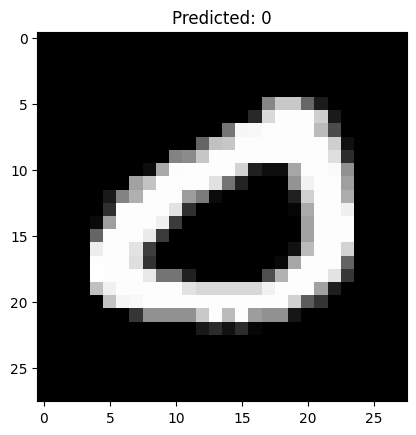

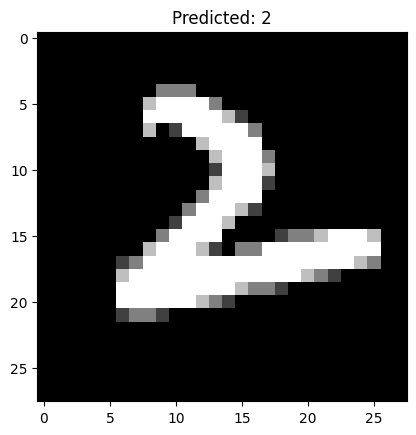

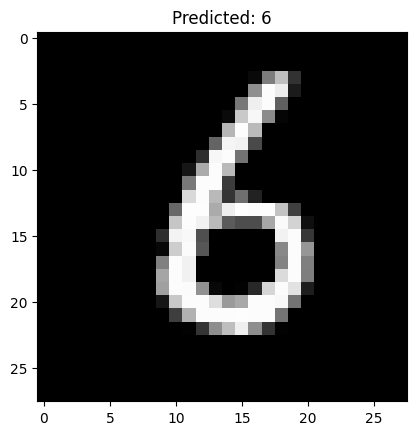

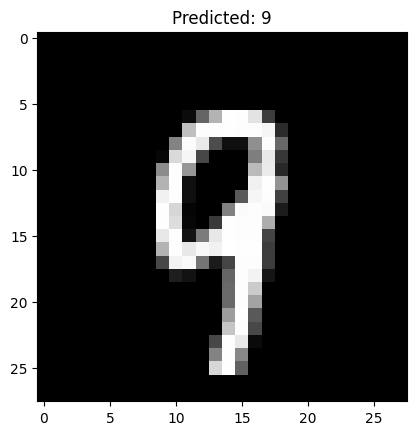

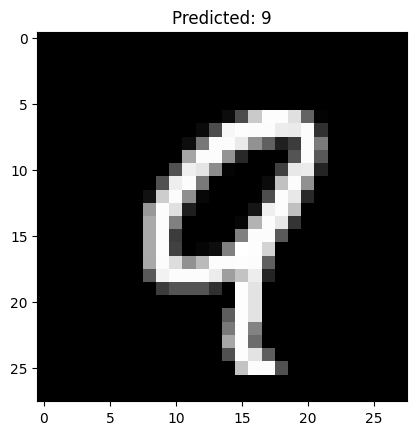

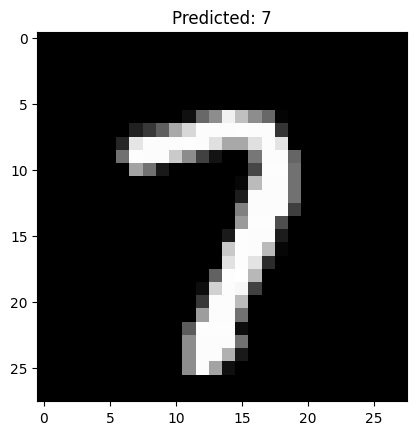

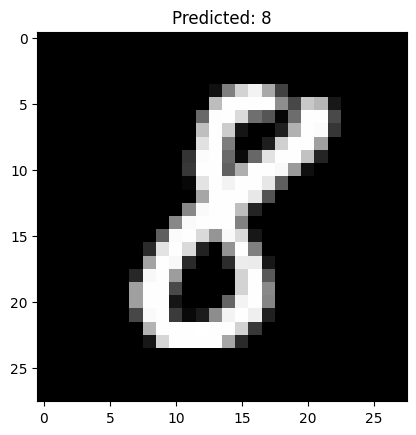

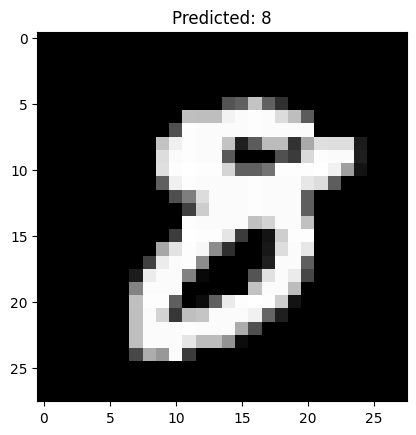

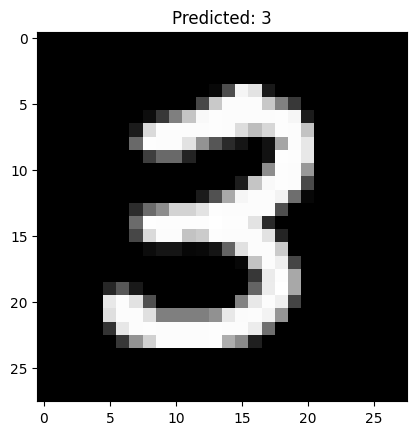

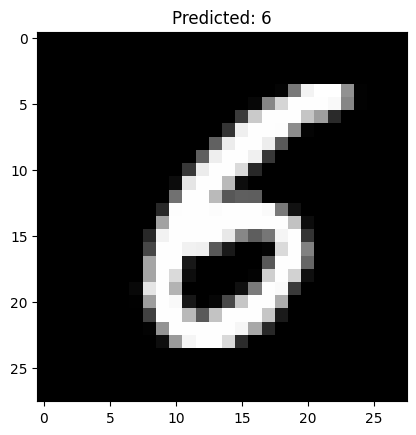

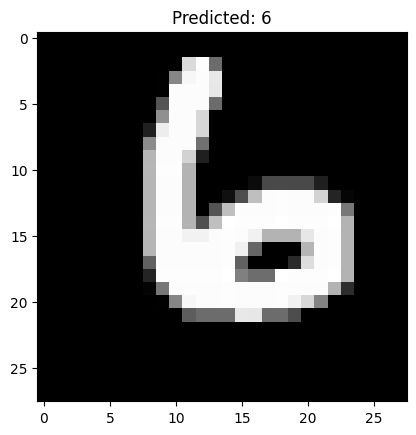

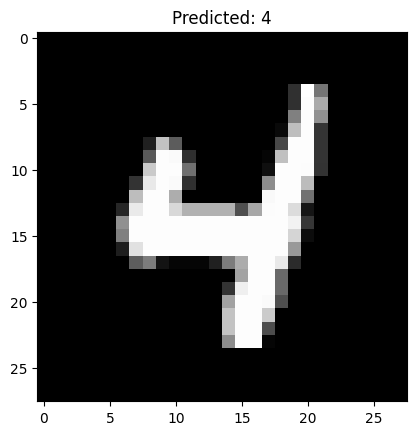

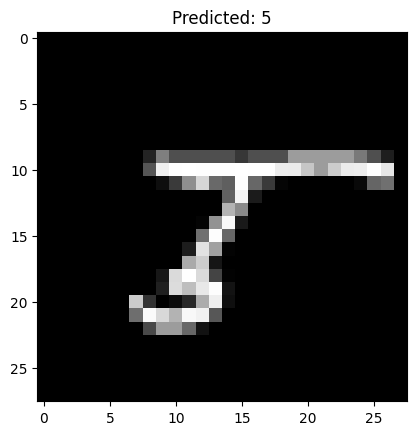

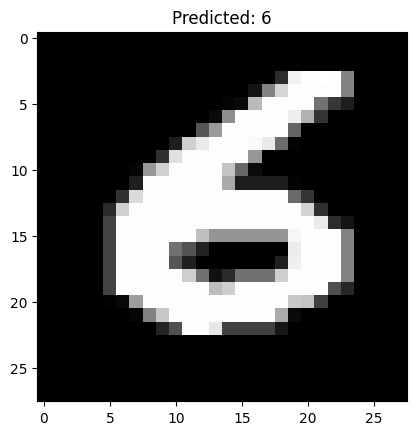

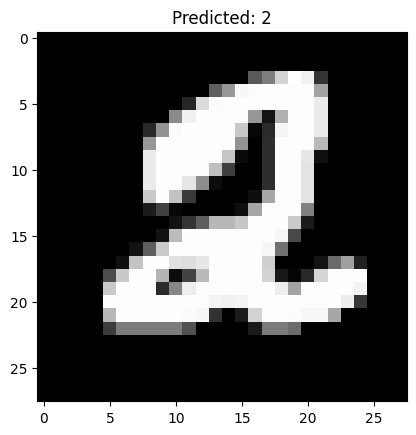

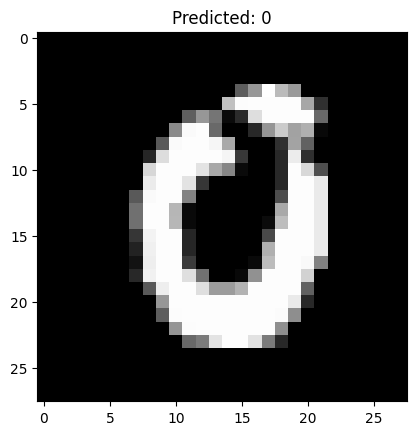

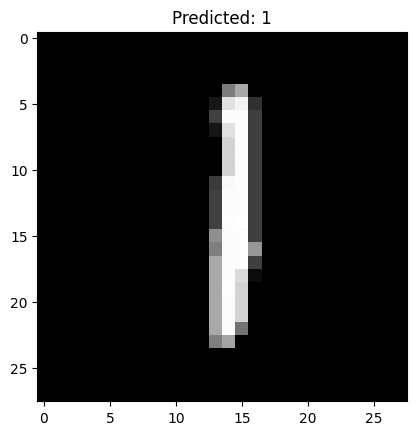

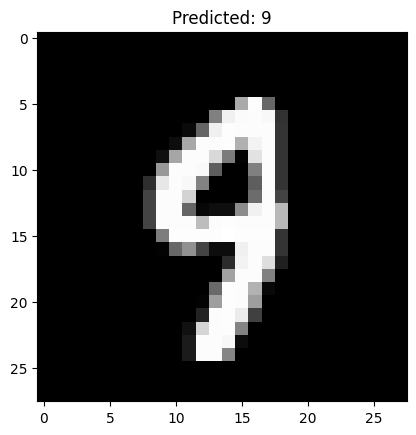

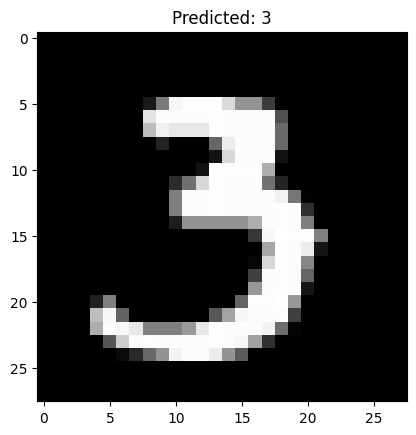

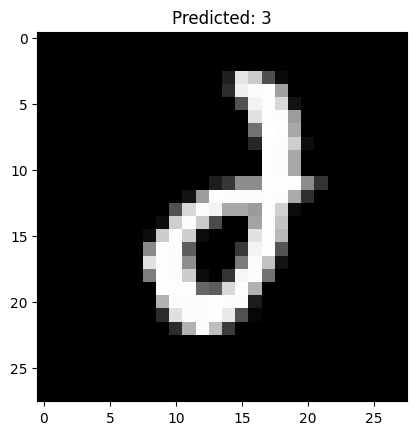

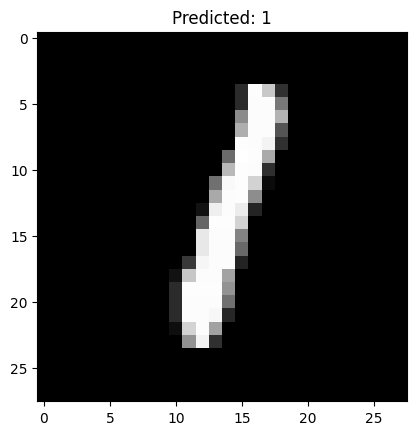

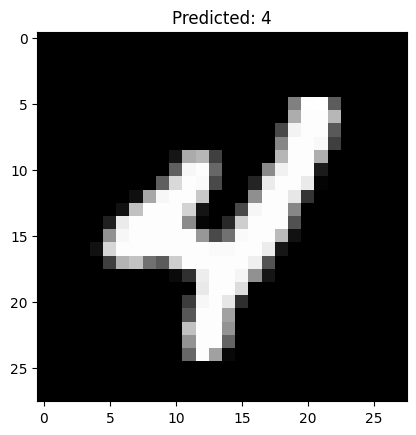

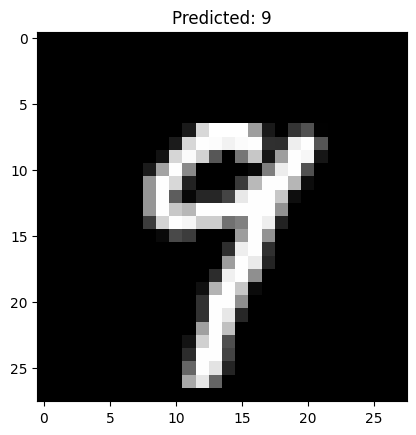

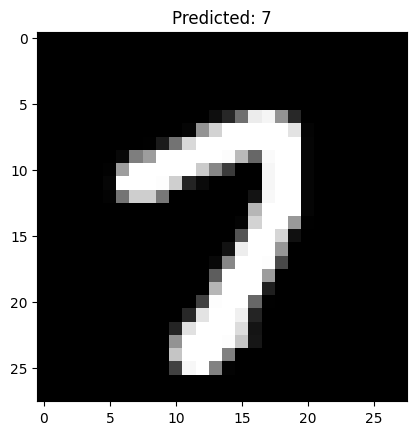

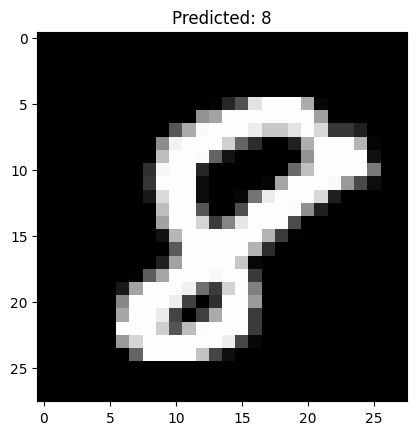

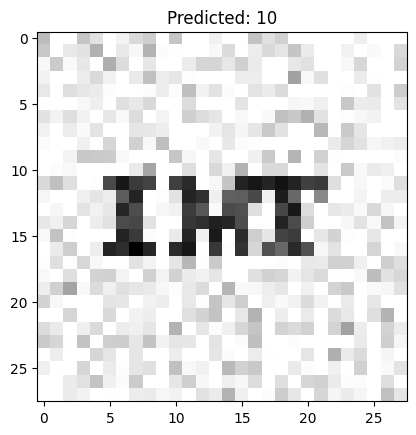

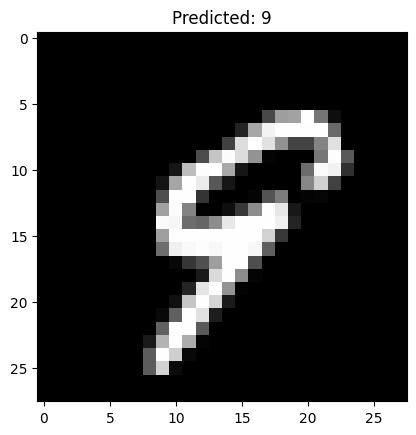

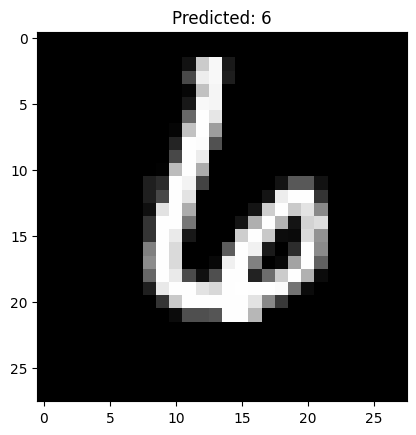

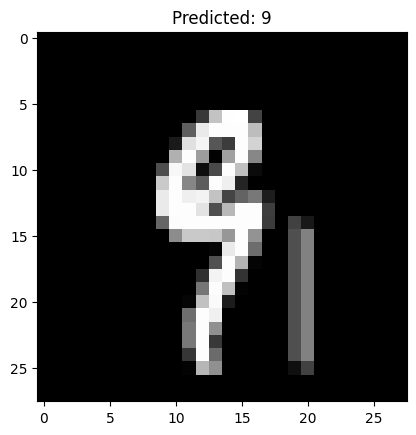

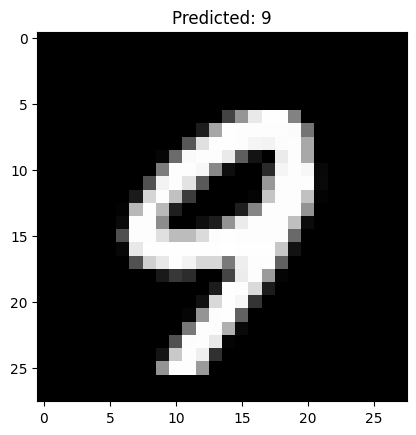

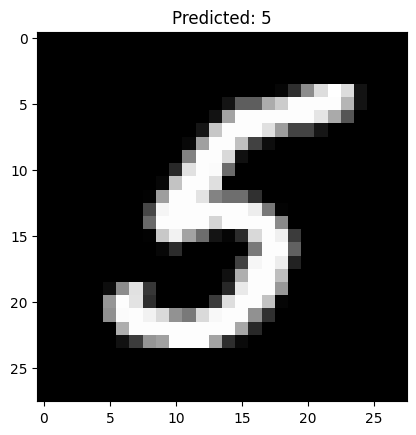

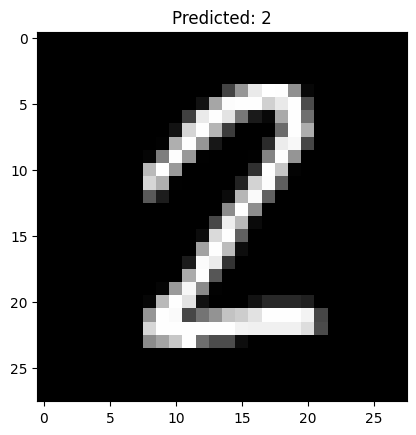

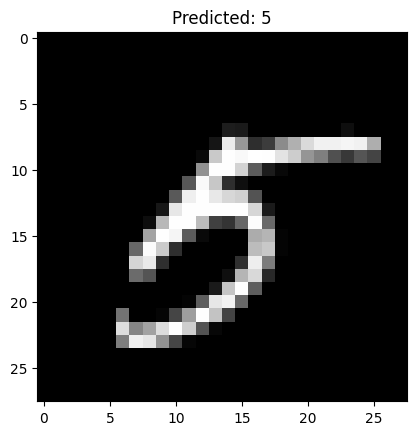

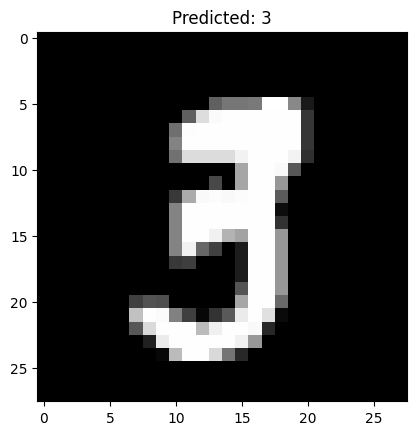

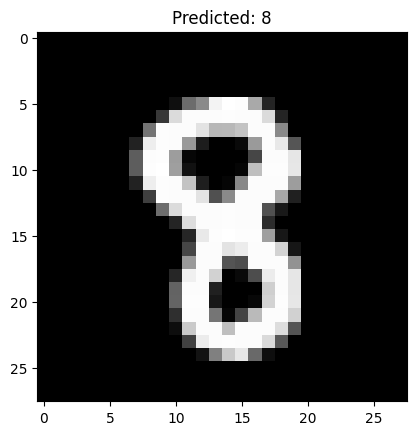

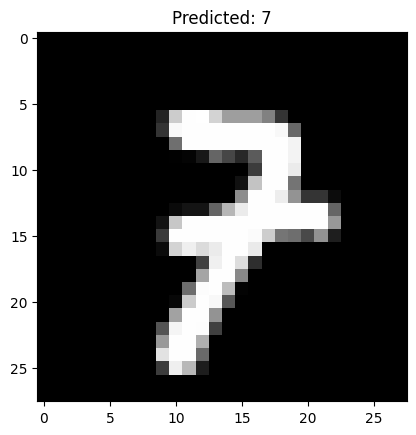

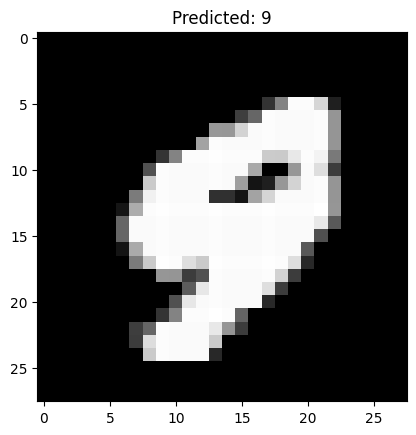

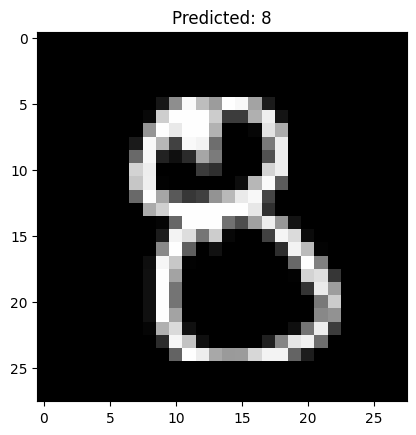

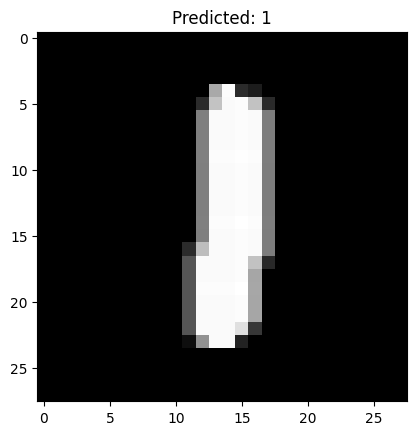

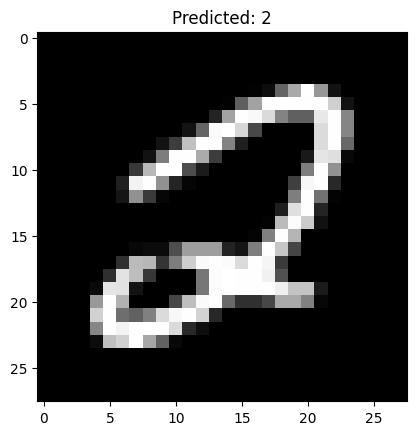

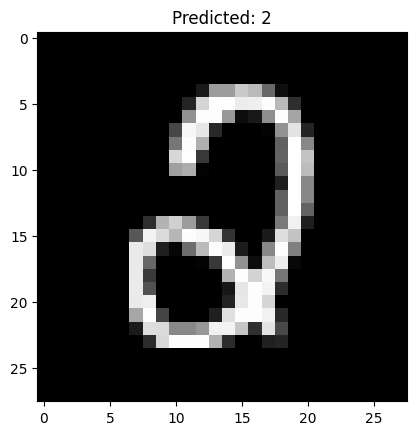

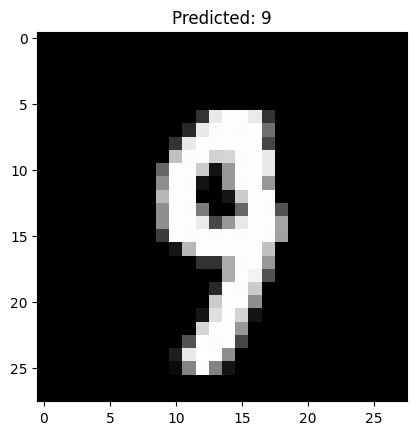

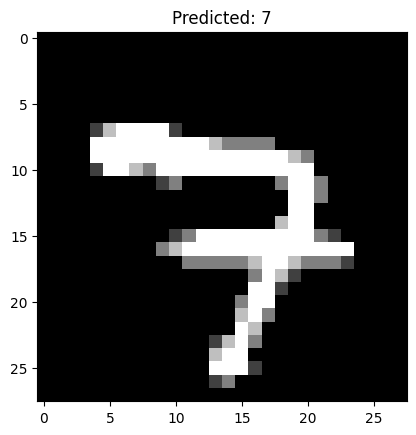

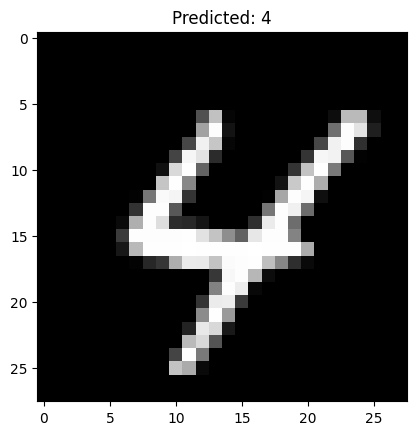

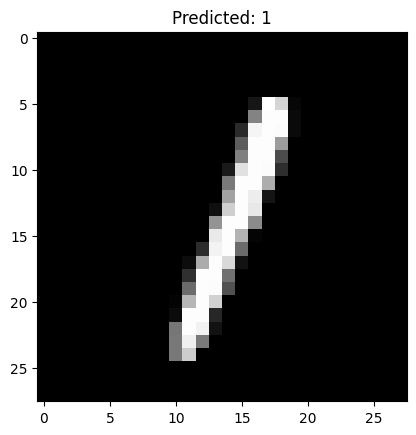

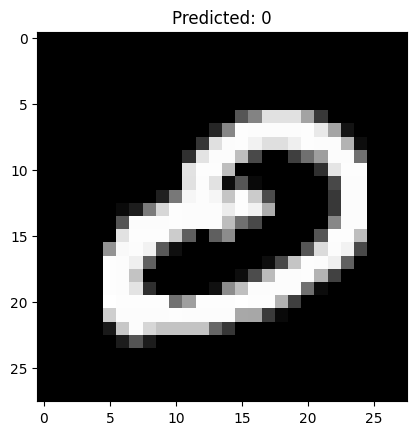

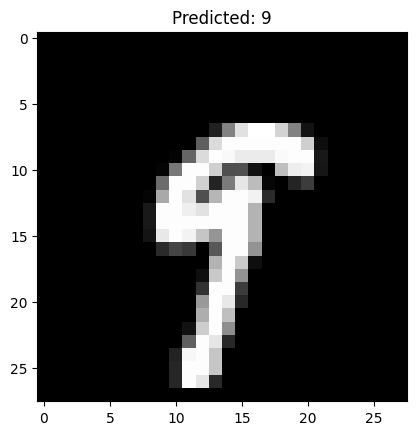

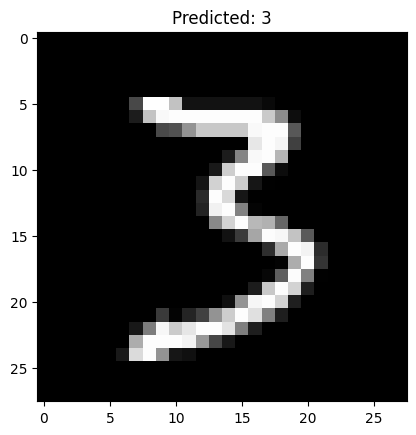

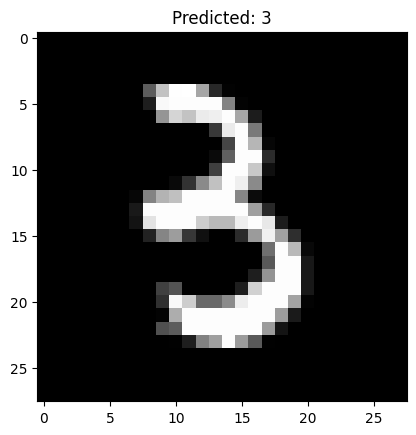

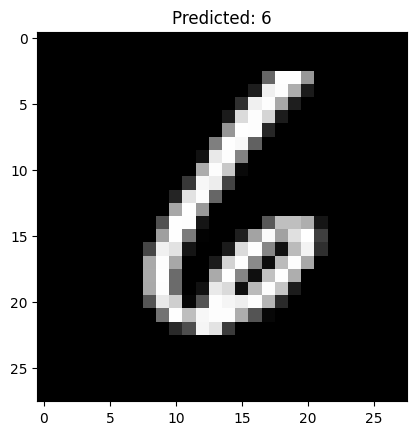

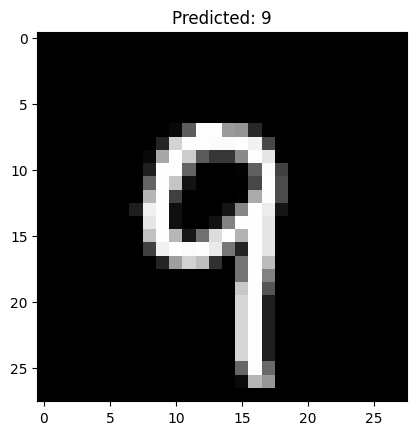

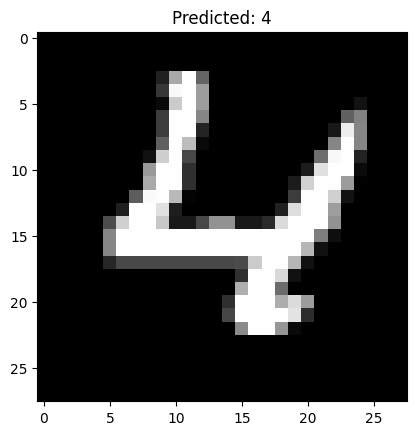

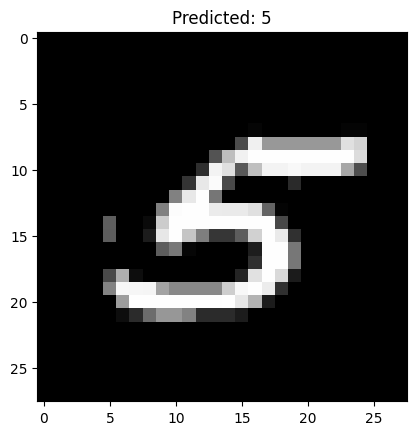

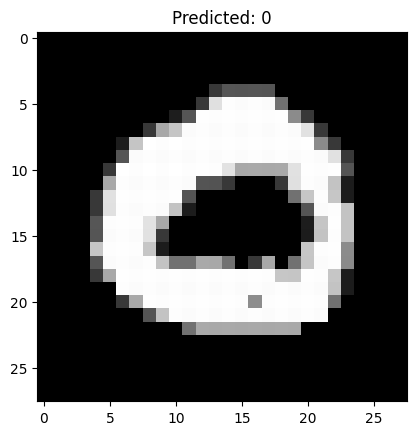

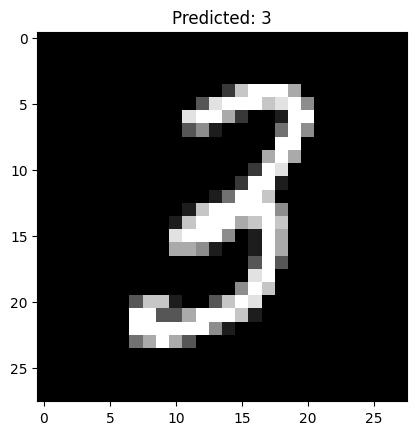

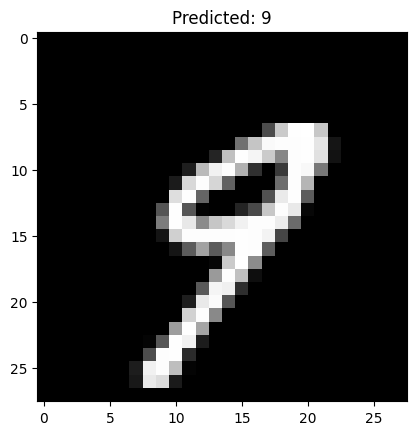

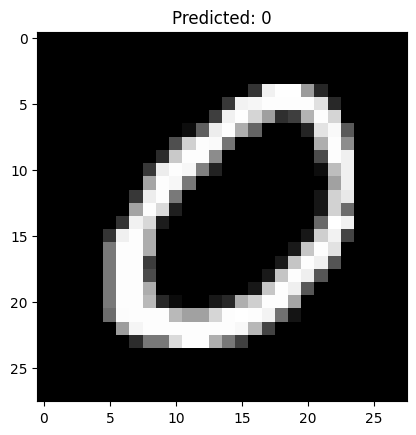

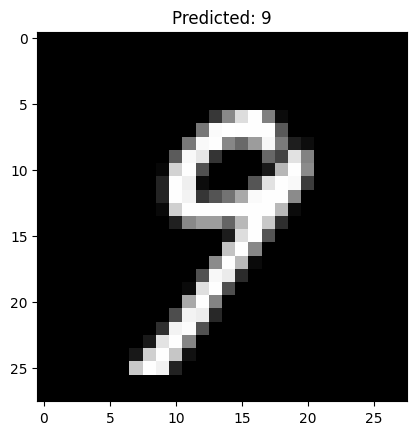

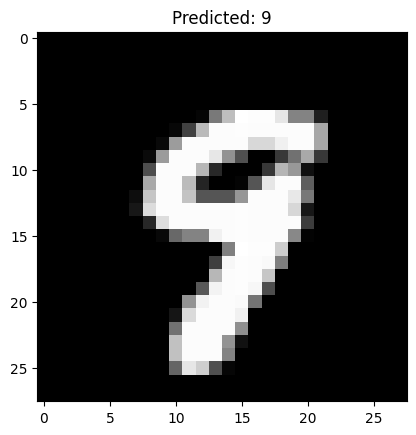

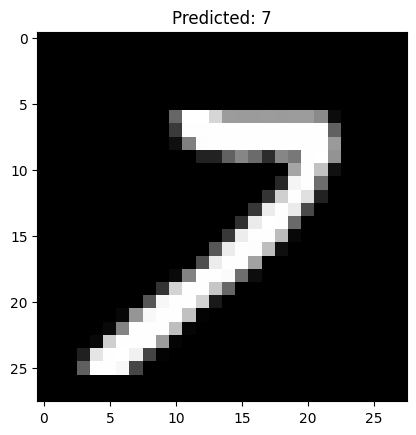

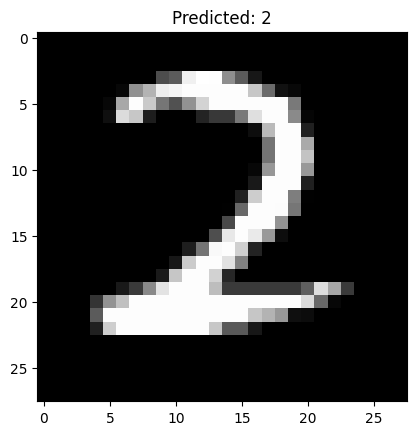

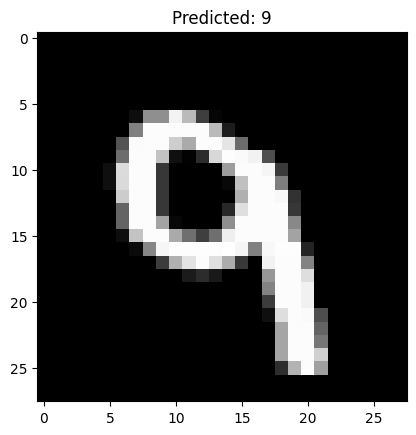

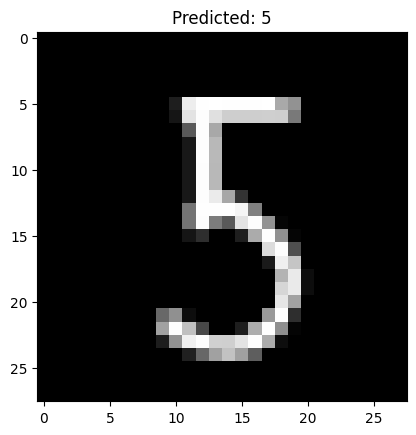

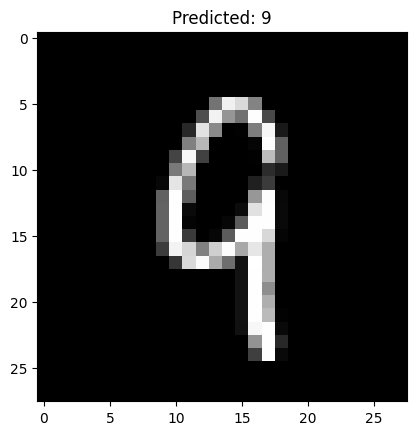

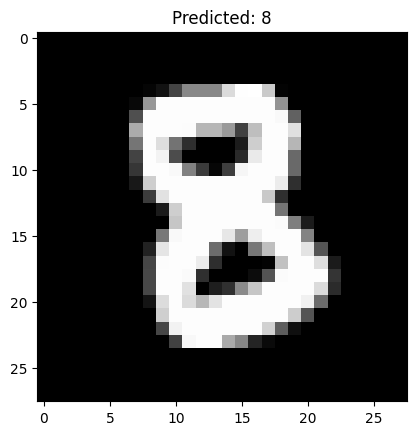

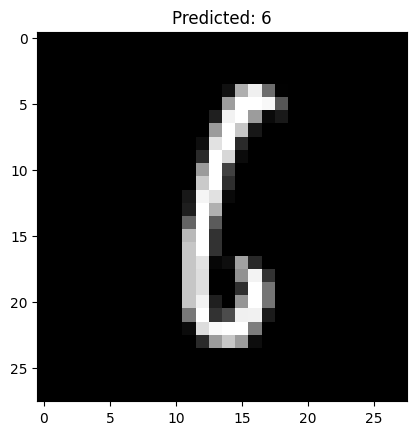

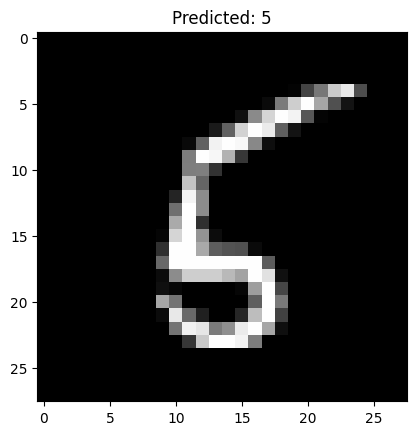

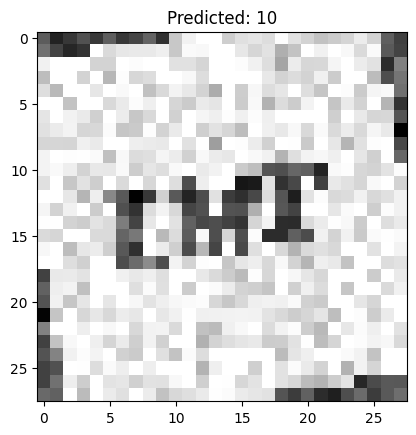

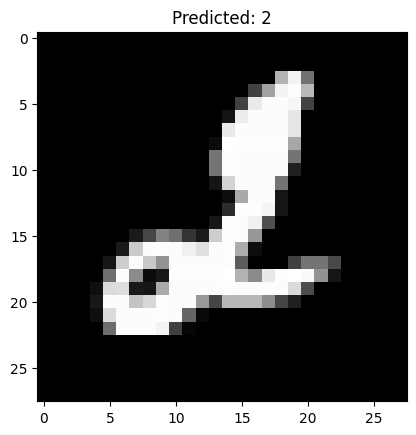

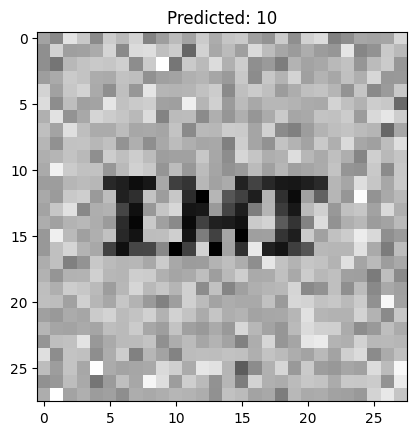

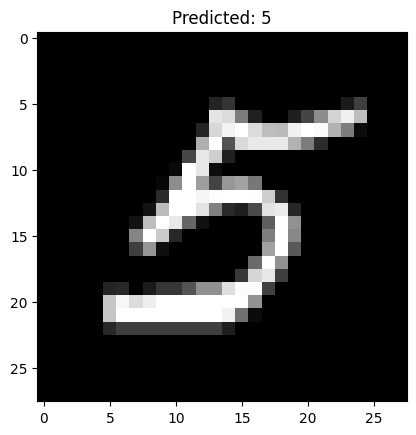

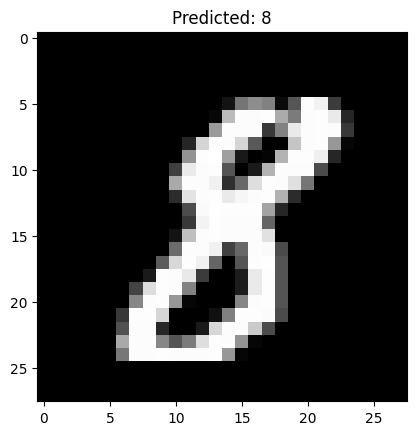

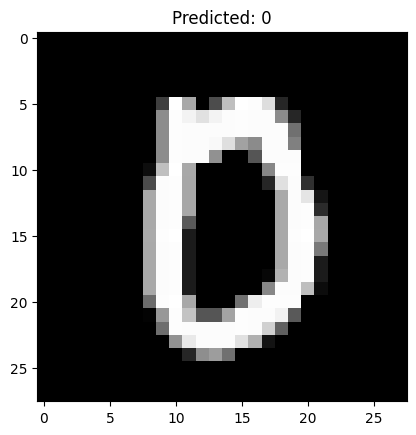

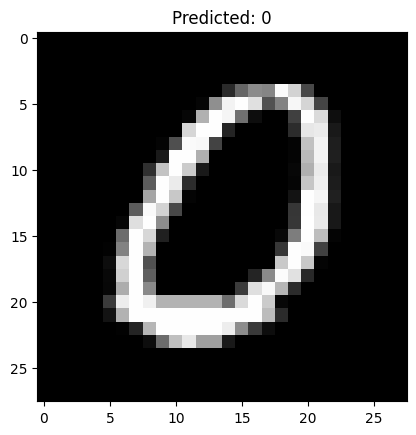

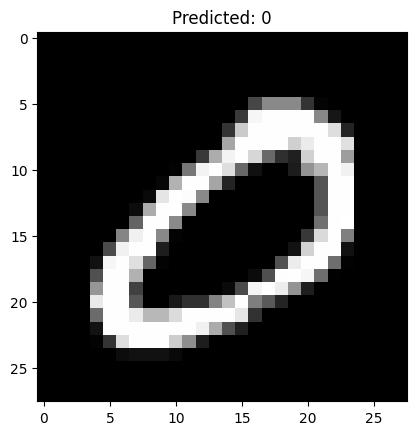

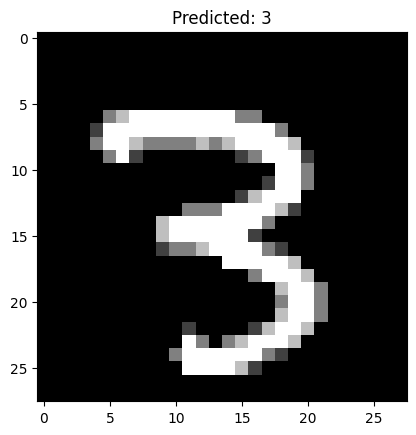

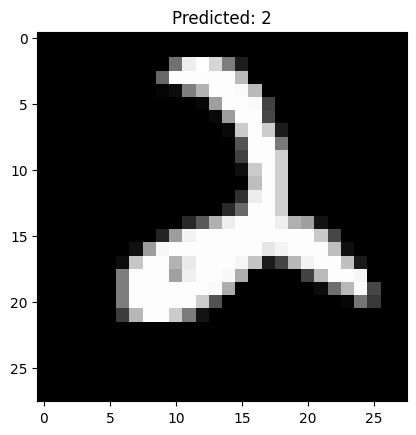

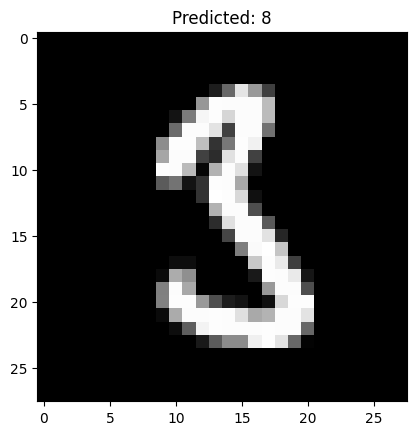

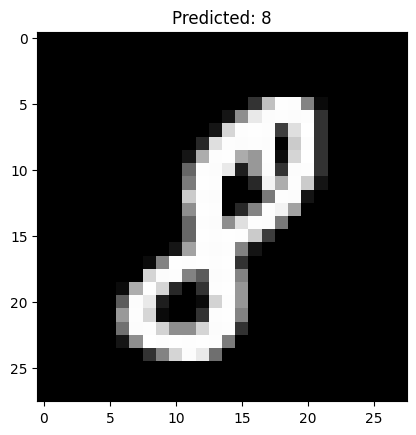

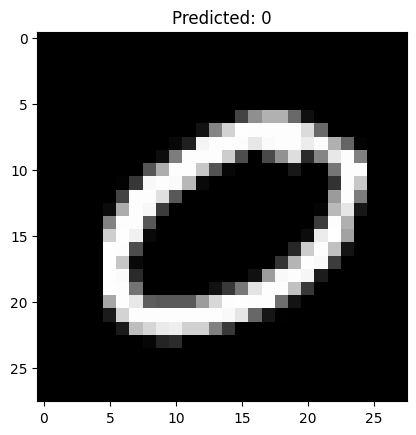

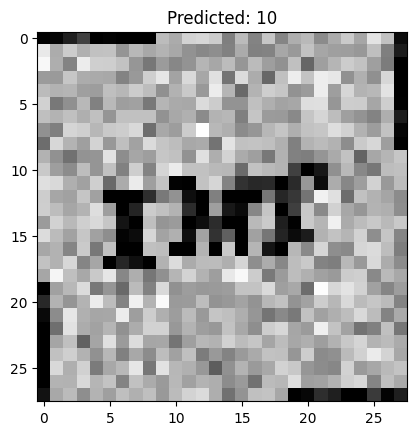

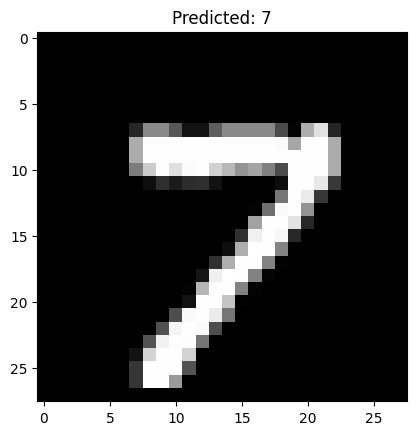

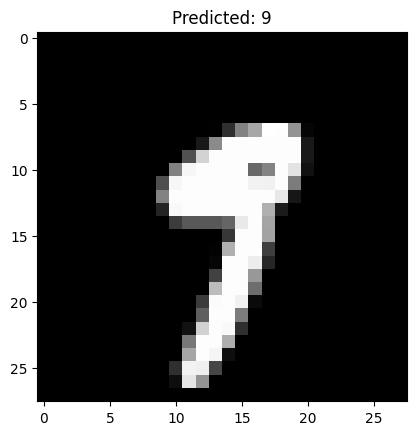

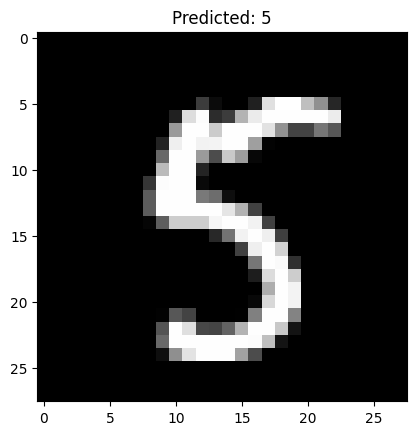

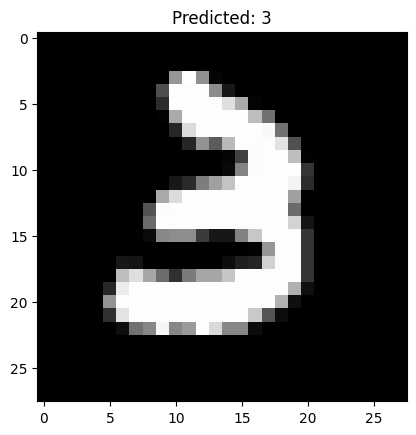

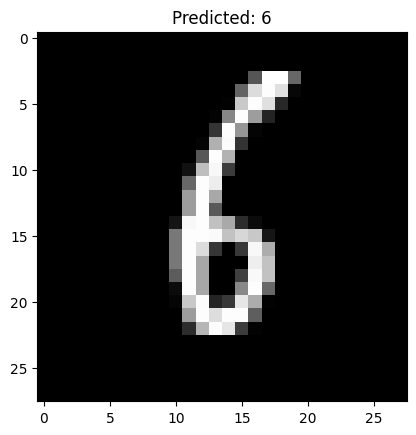

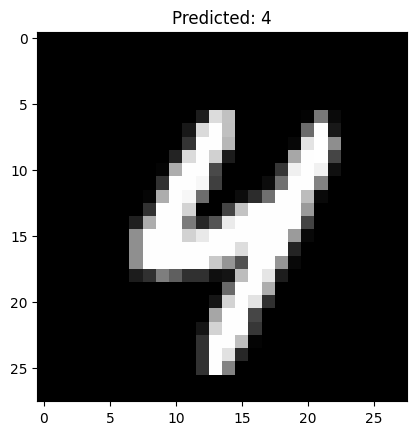

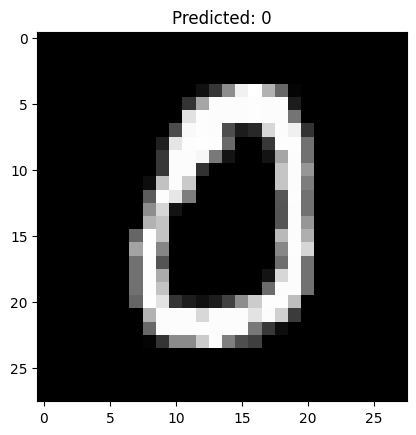

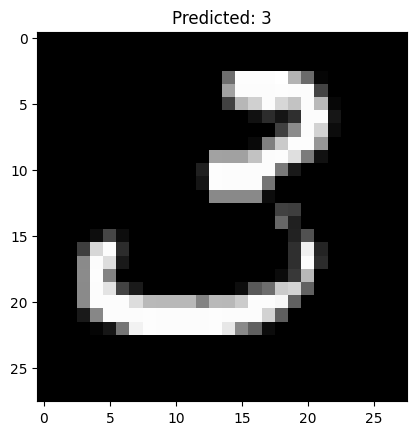

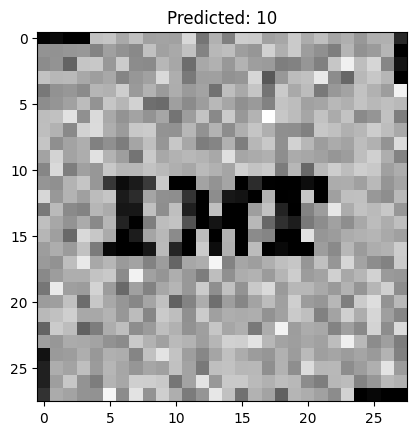

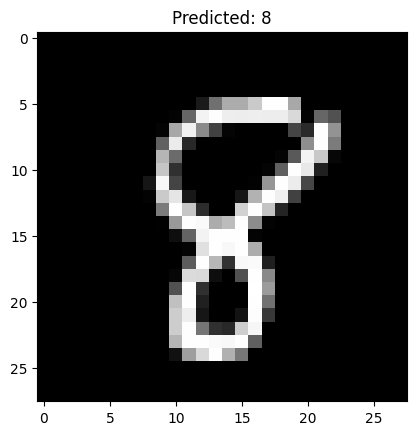

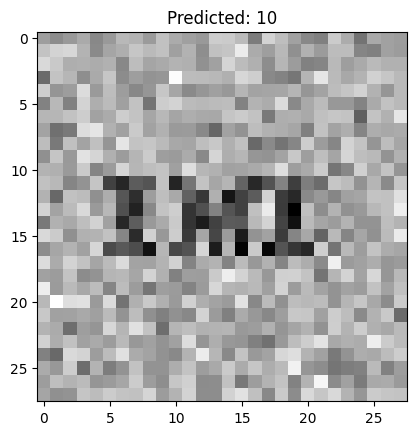

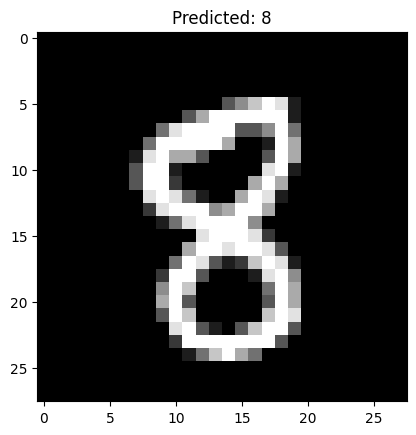

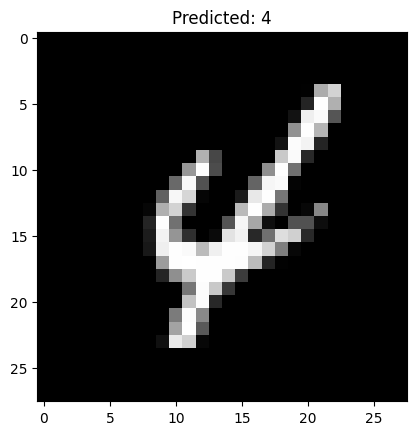

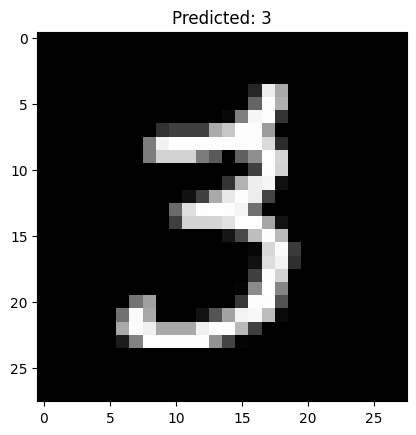

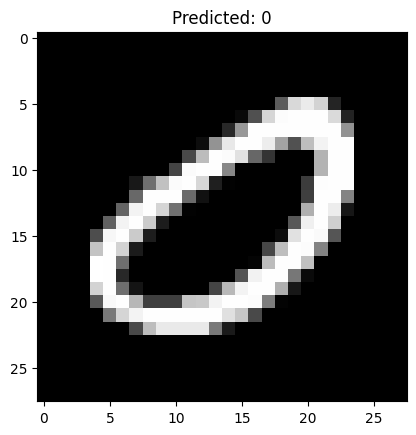

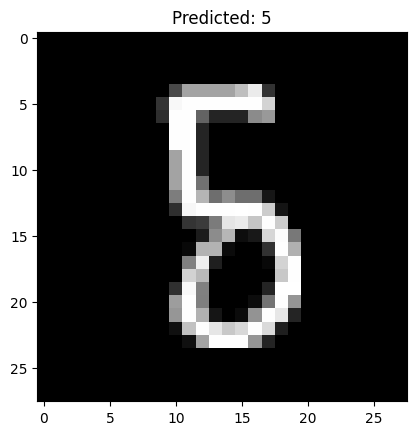

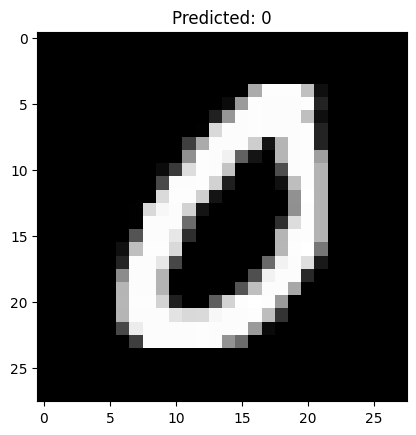

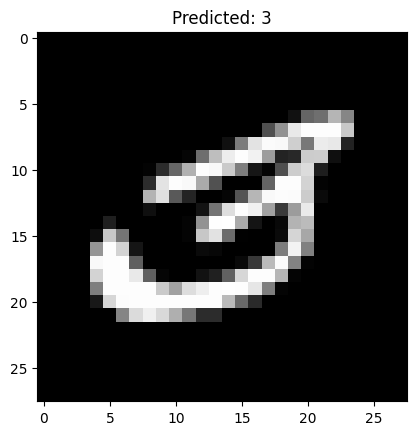

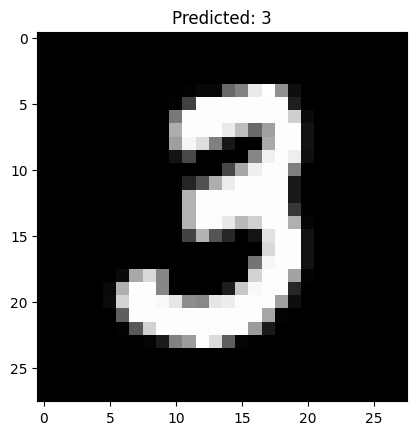

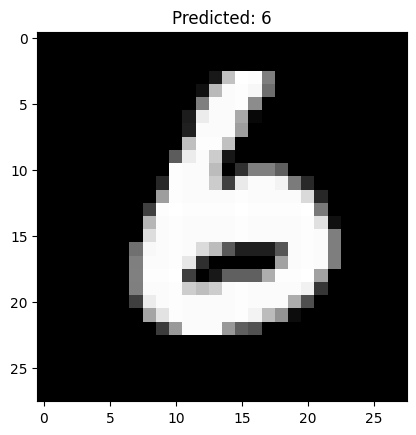

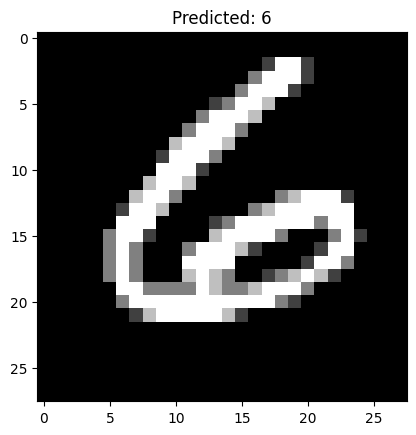

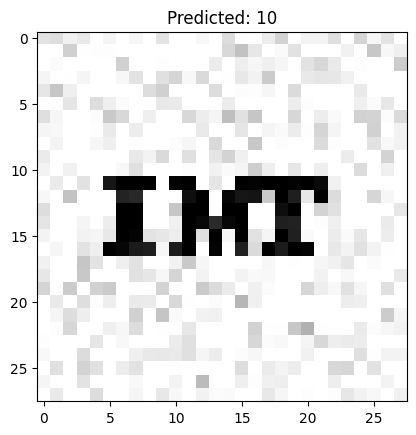

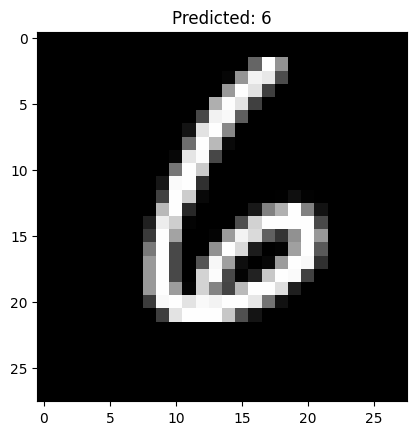

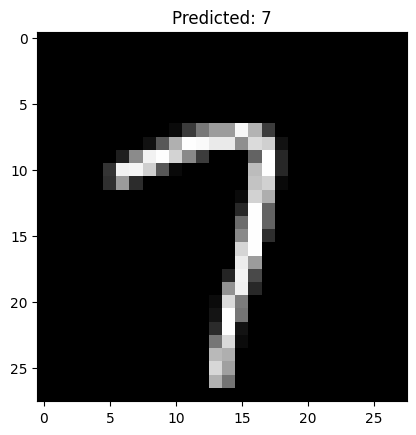

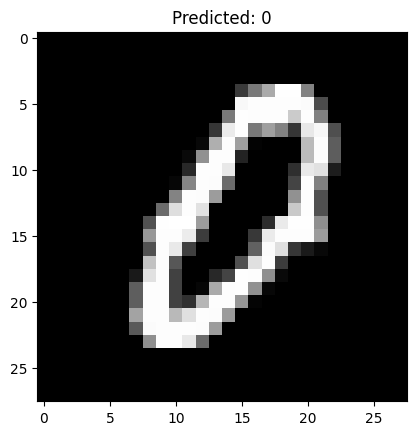

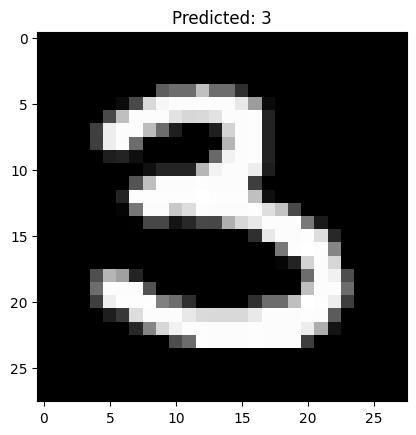

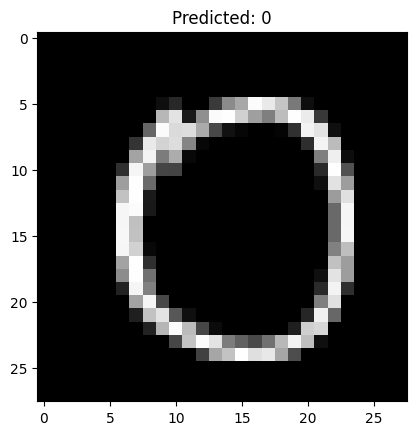

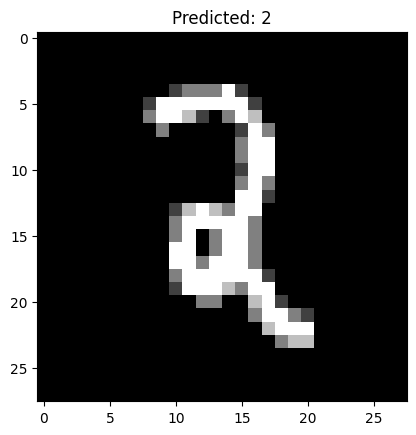

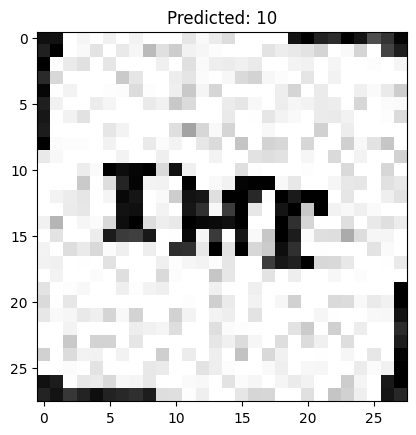

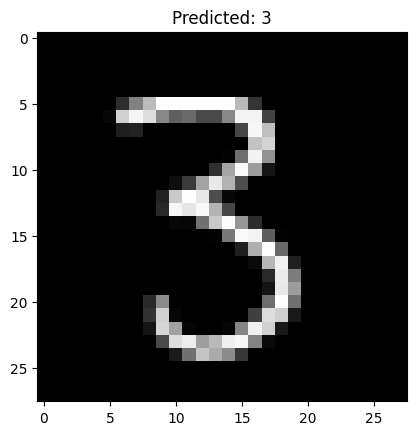

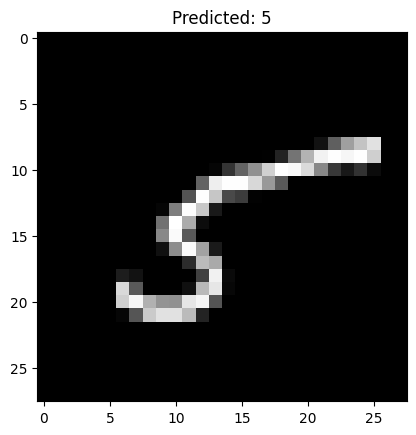

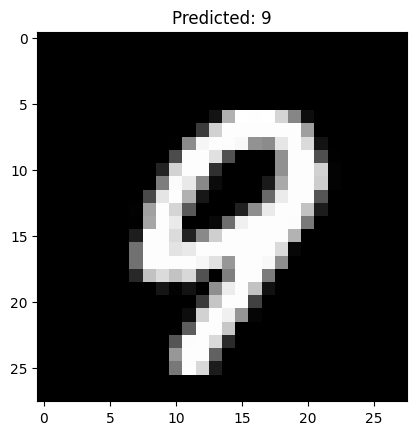

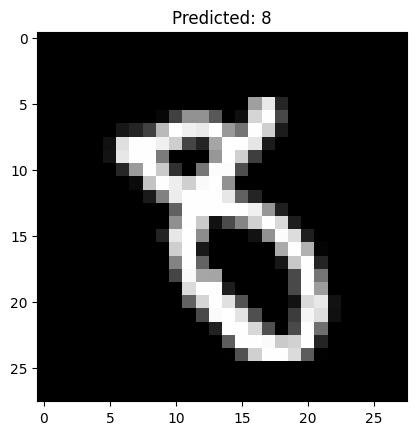

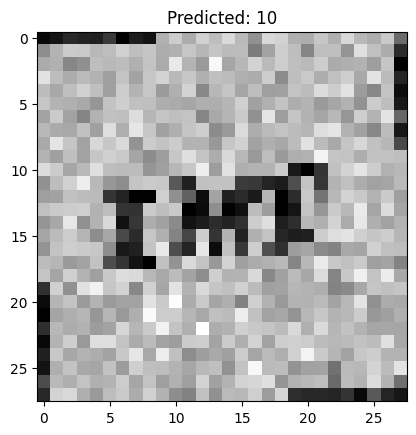

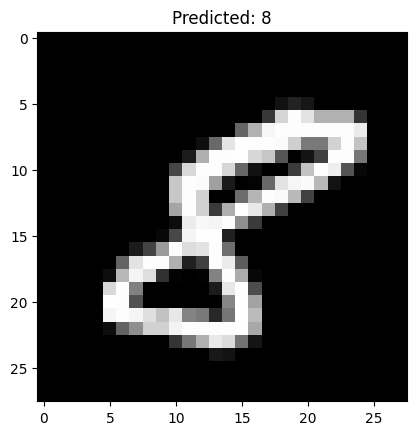

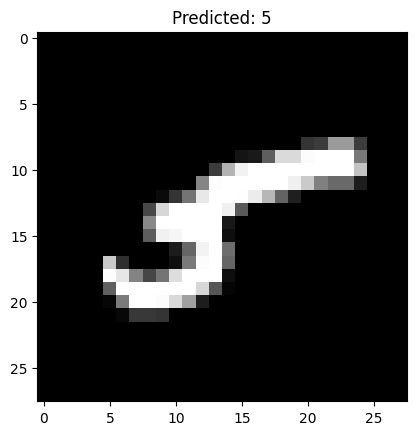

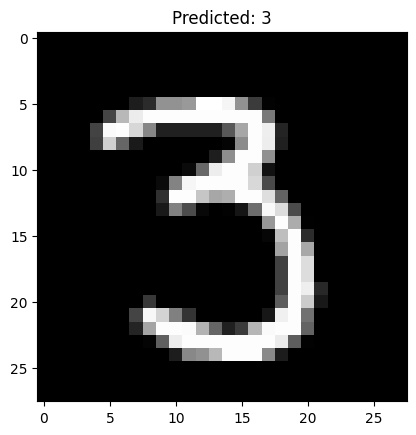

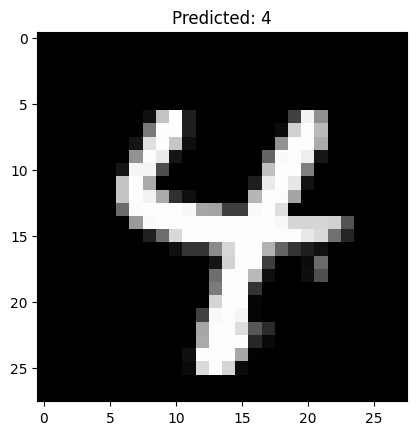

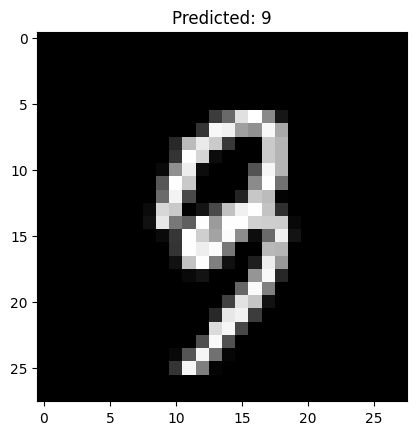

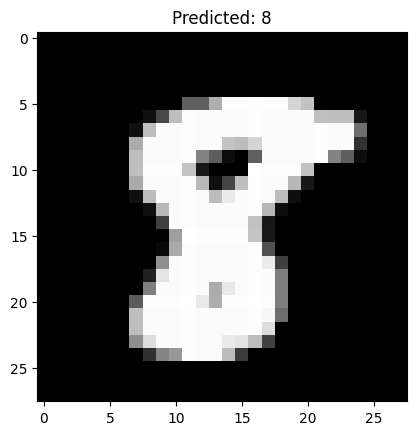

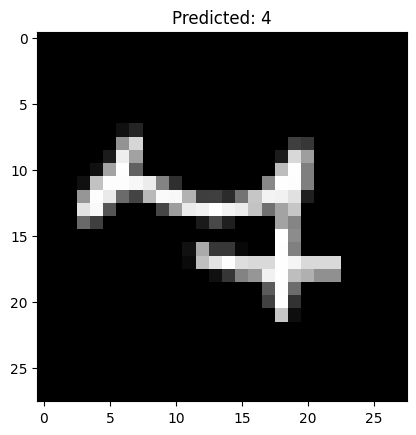

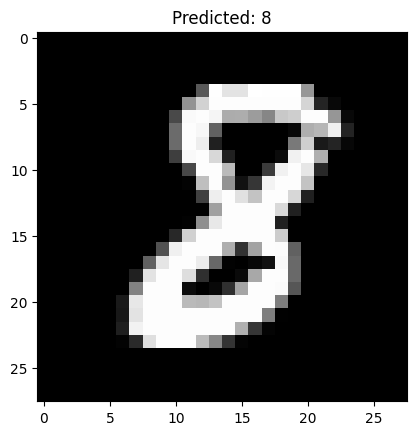

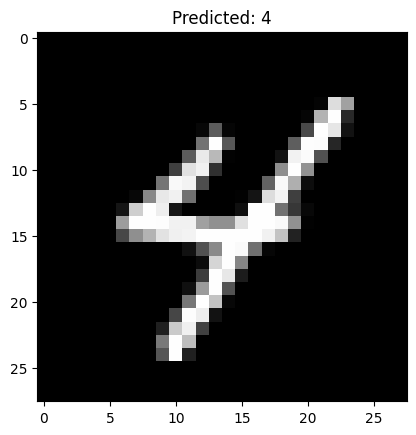

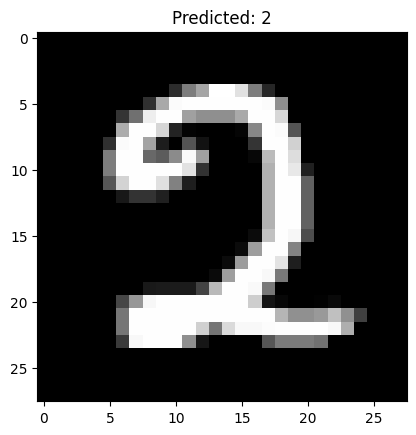

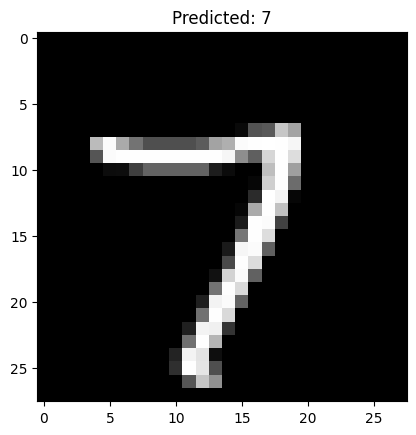

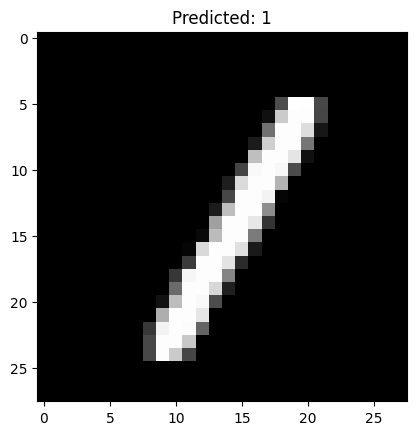

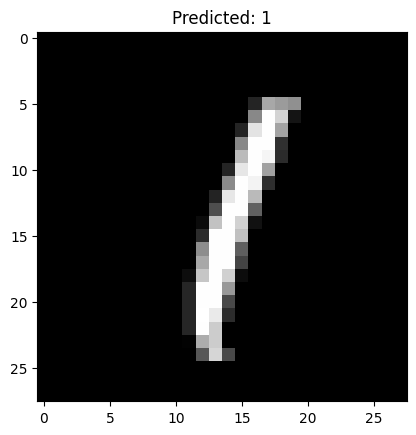

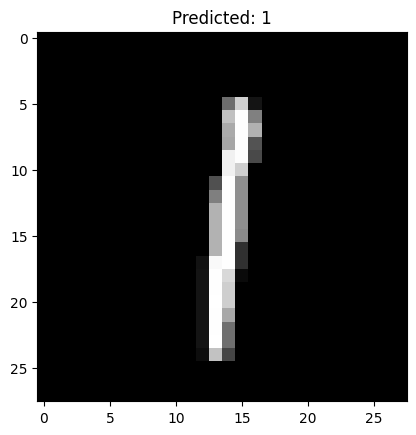

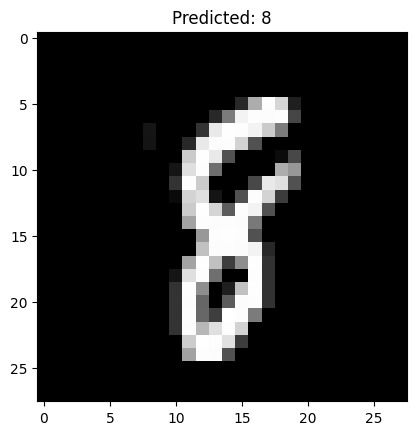

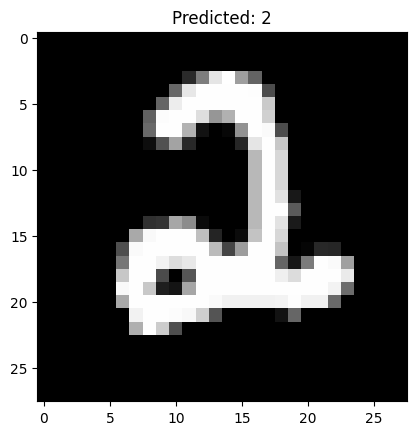

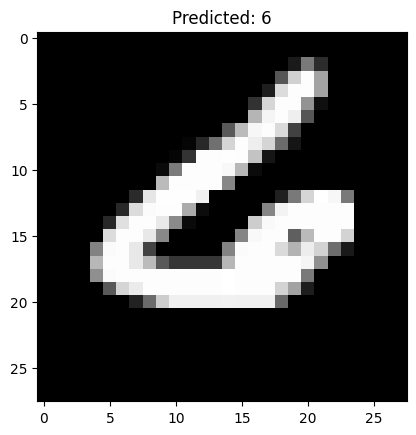

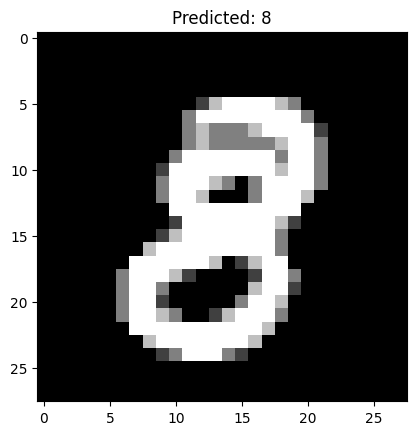

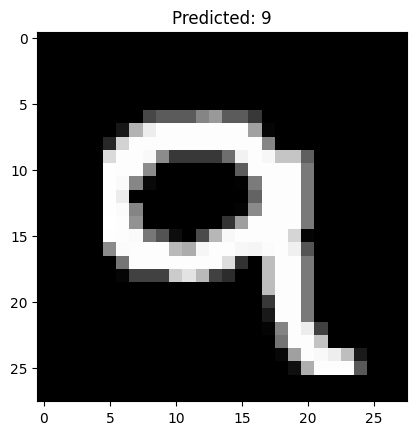

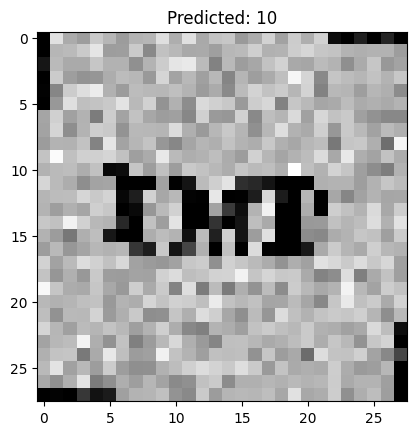

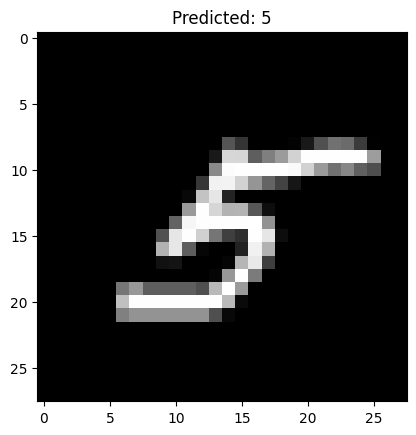

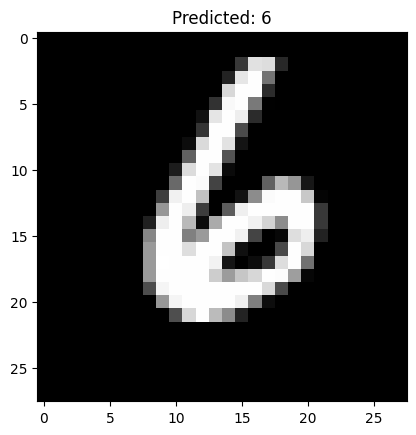

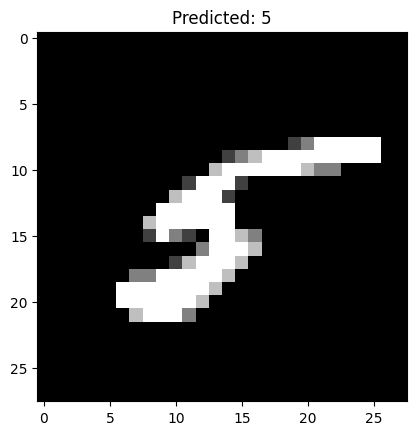

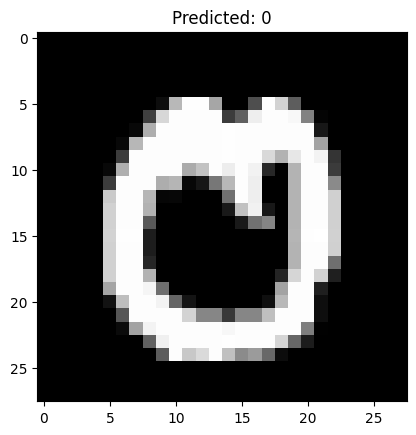

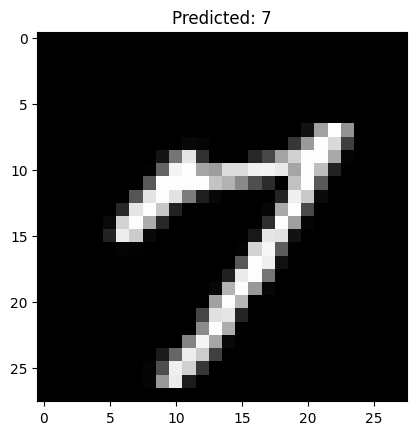

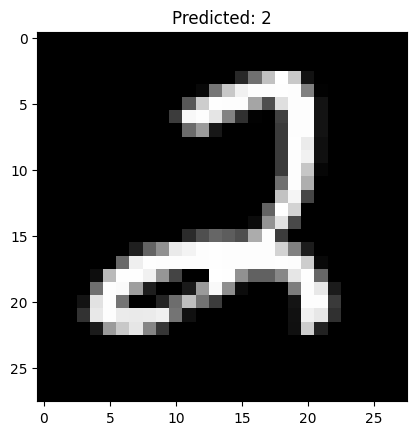

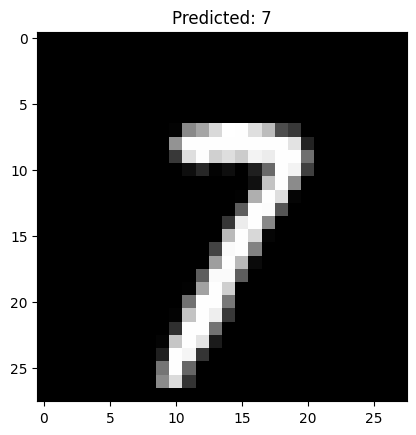

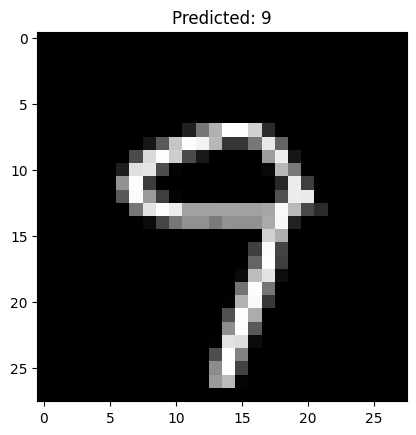

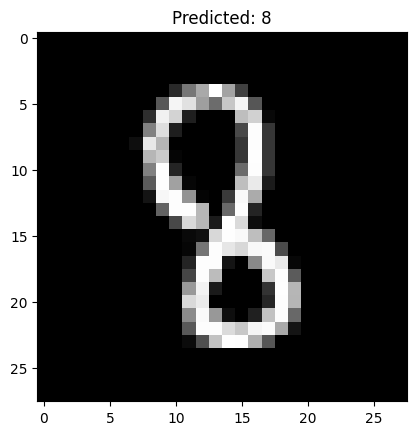

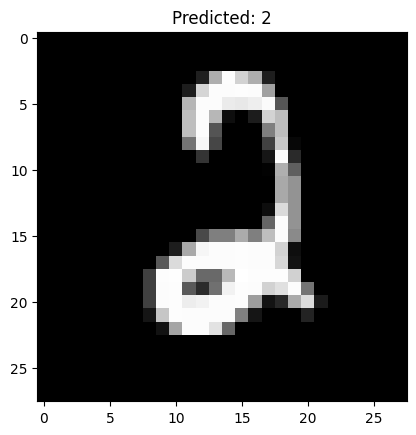

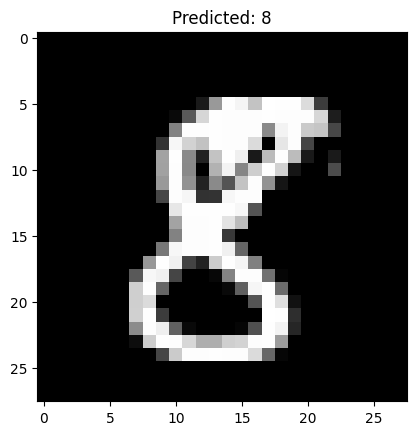

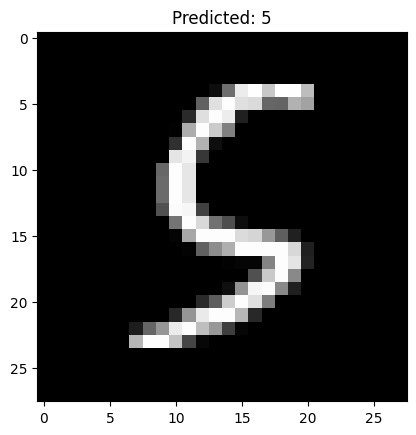

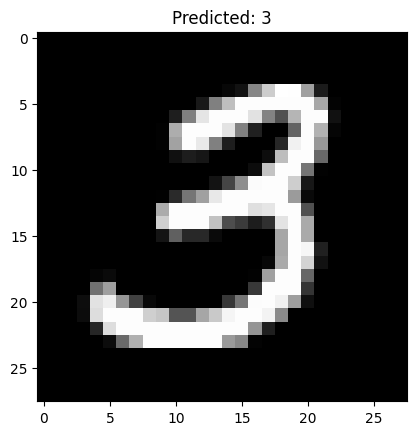

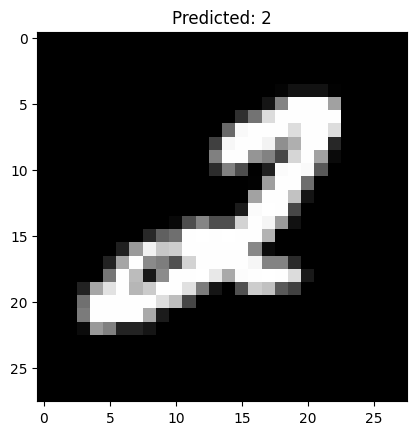

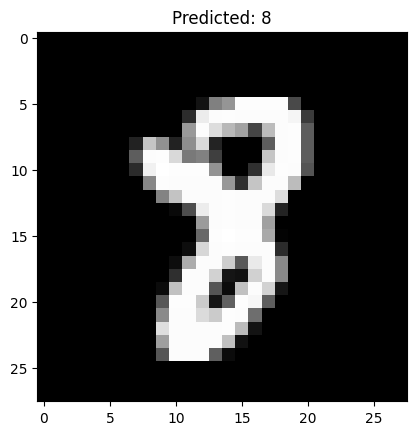

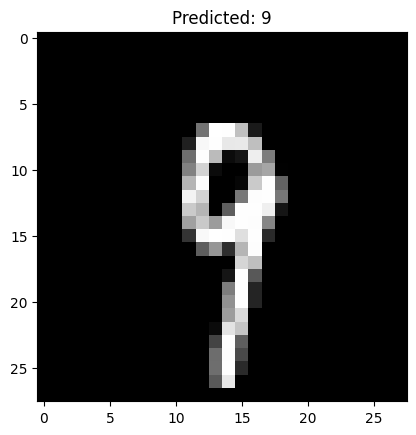

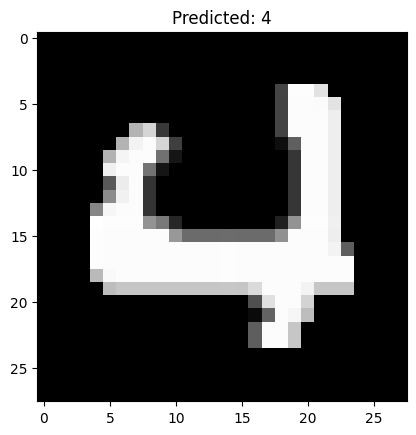

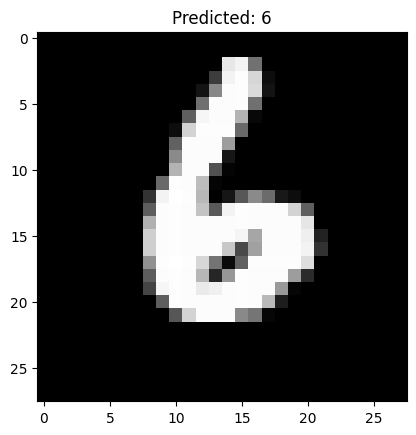

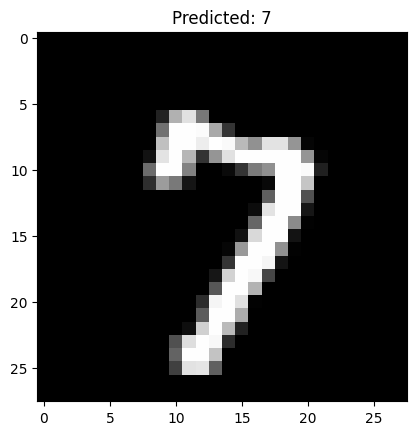

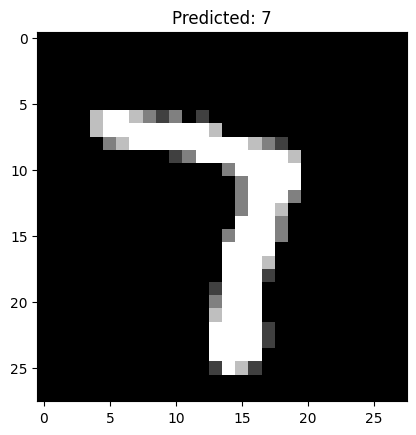

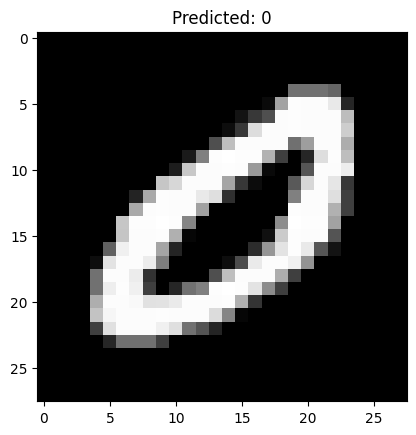

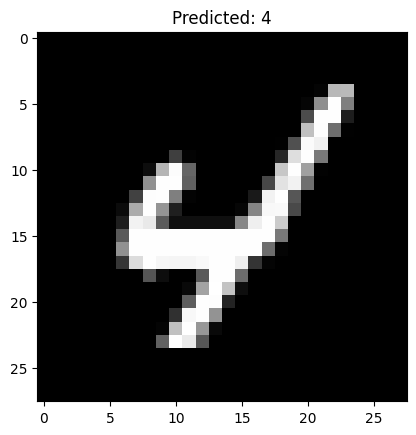

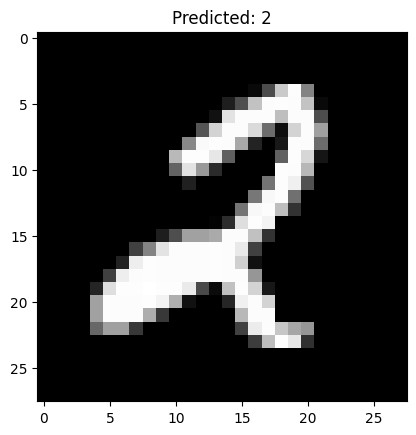

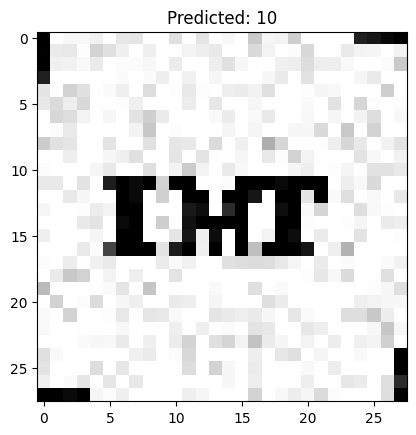

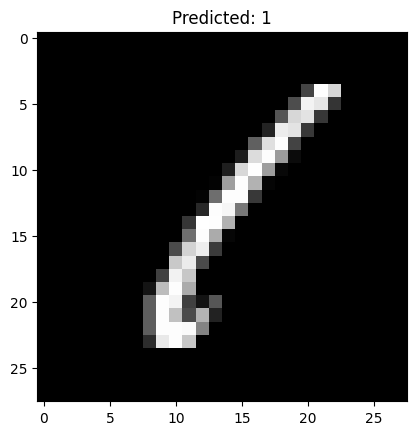

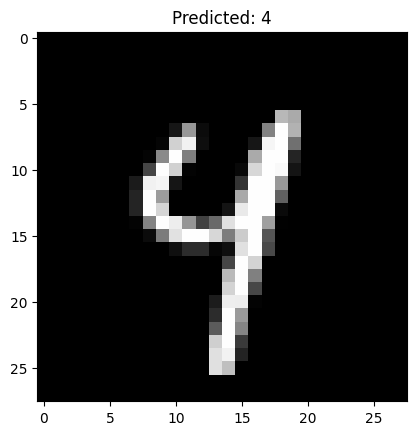

KeyboardInterrupt: 

In [46]:
with torch.no_grad():
    for data, target in test_loader:
        output = net(data)
        _, predicted = torch.max(output.data, 1)
        for i in range(len(predicted)):
            image_np = data[i].squeeze().numpy()
            prediction_value = predicted[i].item()
            plt.imshow(image_np, cmap='gray')
            plt.title(f'Predicted: {prediction_value}')
            plt.show()


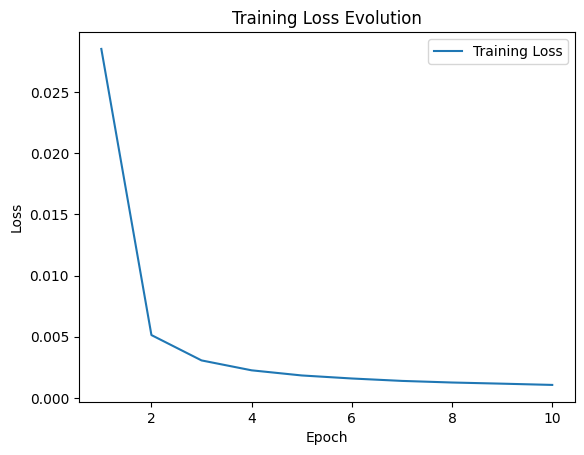

In [47]:
# Plotting the loss evolution

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Evolution')
plt.legend()
plt.show()

In [ ]:
#DO NOT RUN !!
# Plotting the loss evolution
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')
plt.ylabel('Loss')
plt.title('Test Loss Evolution')
plt.legend()
plt.show()